# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

<ipython-input-1-1499ab5789c7>:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle
import random
from random import sample

# general analysis tool-kit
import numpy as np
import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

#from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})

# original library
sys.path.append('/home/hiroki/research/dcase2021_task2/src/functions')
import common as com
import pytorch_modeler as modeler
from pytorch_model import Conditional_VAE as Model
#from pytorch_utils import filtered_load_model
#import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
log_file = config['IO_OPTION']['OUTPUT_ROOT']+'/train_{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_file, '00_train.py')

## Setting

In [5]:
# Setting seed
modeler.set_seed(777)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
#dev_dir = INPUT_ROOT + "/dev_data"
#add_dev_dir = INPUT_ROOT + "/add_dev_data"
# machine type
machine_types = ['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
OUT_FEATURE_DIR = OUTPUT_ROOT + '/extraction_features'
OUT_SCORE_DIR = OUTPUT_ROOT + '/score'
OUT_PRED_DIR = OUTPUT_ROOT + '/pred'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(OUT_FEATURE_DIR, exist_ok=True)
os.makedirs(OUT_SCORE_DIR, exist_ok=True)
os.makedirs(OUT_PRED_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/HDD1TB/research/dcase2021_task2/output/CenterLossVAE/ex15/config.yaml'

In [7]:
torch.cuda.is_available()

True

In [8]:
ext_data = pd.read_pickle(f'{INPUT_ROOT}/valve_features.pkl')

In [9]:
#train_features = ext_data['train']['features']

In [10]:
#train_features.shape

## training

In [11]:
def random_feature_selection(x, t_d=3776, d=2048):
    idx = torch.tensor(sample(range(0, t_d), d)) # t_d(特徴量)の中からランダムにd個サンプリングする(ぜんぶやると重いから) # わからん
    # 0~t_d idxの中からランダムにd個サンプリングする
    x = np.take(x, idx, 1)
    return x

In [12]:
#ext_data['train'].keys()

In [13]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dataloader
    #for machine in machine_types:
    #    if machine_type == machine:
    #        ext_data = pd.read_pickle(f'{INPUT_ROOT}/{machine}_features.pkl')
    #    else:
    #        ext_data_ = pd.read_pickle(f'{INPUT_ROOT}/{machine}_features.pkl')
    #        ext_data['train']['features'] = np.concatenate([ext_data['train']['features'],
    #                                                        ext_data_['train']['features']], axis=0)
    #        ext_data['train']['labels'] = np.concatenate([ext_data['train']['labels'],
    #                                                     ext_data_['train']['labels']], axis=0)
    #        ext_data['train']['wav_names'] = np.concatenate([ext_data['train']['wav_names'],
    #                                                         ext_data_['train']['wav_names']], axis=0)
            
    #t_d = 3776    # 全特徴量数
    #d = 1024      # 使う特徴量数
    #for phase in ['train', 'valid_source', 'valid_target']:
    #    x = ext_data[phase]['features']
    #    x = random_feature_selection(x)
    #    ext_data[phase]['features'] = x
    #    x = ext_data[phase]['features'][:,512:2048]
    #    ext_data[phase]['features'] = x
    dataloaders_dict = modeler.make_dataloader(ext_data)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    # out path
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    score_out_path = OUT_SCORE_DIR + '/{}_score.csv'.format(machine_type)
    pred_out_path = OUT_PRED_DIR + '/{}_pred.csv'.format(machine_type)
    logger.info('TRAINING')
    # parameter setting
    in_features = ext_data['train']['features'].shape[1]
    mid_size = config['param']['mid_size']
    latent_size = config['param']['latent_size']
    num_classes = 6
    net = Model(in_features, mid_size, latent_size, num_classes)
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    num_epochs = config['param']['num_epochs']
    #scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e-2, 
    #                                          max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(dataloaders_dict['train']))
    # training
    output_dicts = modeler.train_net(net, dataloaders_dict, optimizer, num_epochs, writer, model_out_path, score_out_path, pred_out_path)
    
    com.toc()

In [14]:
machine_types

['ToyCar', 'gearbox', 'valve', 'ToyTrain', 'pump', 'fan', 'slider']

2021-05-31 23:30:38,205 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2021-05-31 23:30:38,206 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-31 23:30:39,320 - 00_train.py - INFO - TRAINING
2021-05-31 23:30:44,392 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:01<00:00,  7.87it/s]
2021-05-31 23:30:45,919 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 89.56it/s]
2021-05-31 23:30:45,964 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 94.22it/s]


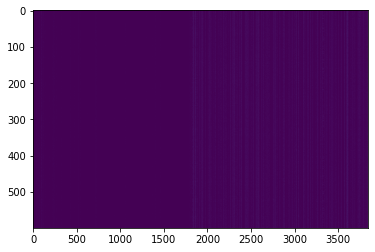

,AUC,pAUC
Source_0,0.609600,0.568421
Source_1,0.500300,0.496842
Source_2,0.412100,0.495263
Target_0,0.584700,0.562105
Target_1,0.540500,0.486316
Target_2,0.500100,0.503684
mean,0.524550,0.518772
h_mean,0.516092,0.516717


2021-05-31 23:30:47,634 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:1433.052399, val_AUC_hmean:0.516092, val_pAUC_hmean:0.516717, best_flag:True
2021-05-31 23:30:47,635 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.32it/s]
2021-05-31 23:30:48,228 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 86.20it/s]
2021-05-31 23:30:48,277 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 66.19it/s]


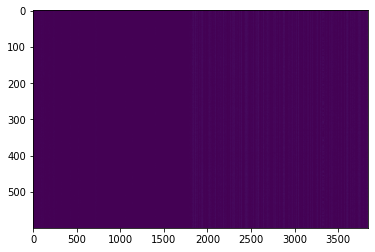

,AUC,pAUC
Source_0,0.656500,0.603684
Source_1,0.493000,0.505789
Source_2,0.499900,0.495263
Target_0,0.611700,0.587368
Target_1,0.527800,0.492632
Target_2,0.522700,0.497895
mean,0.551933,0.530439
h_mean,0.545722,0.526611


2021-05-31 23:30:50,077 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:1049.415843, val_AUC_hmean:0.545722, val_pAUC_hmean:0.526611, best_flag:True
2021-05-31 23:30:50,078 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.51it/s]
2021-05-31 23:30:50,907 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 74.62it/s]
2021-05-31 23:30:50,959 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 73.18it/s]


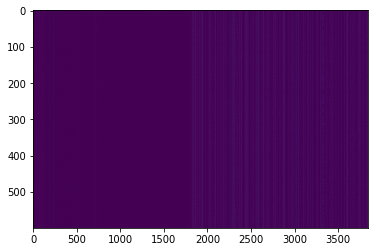

,AUC,pAUC
Source_0,0.700400,0.598421
Source_1,0.499200,0.501579
Source_2,0.573900,0.513684
Target_0,0.640700,0.601053
Target_1,0.530200,0.492105
Target_2,0.540600,0.496316
mean,0.580833,0.533860
h_mean,0.573061,0.529934


2021-05-31 23:30:52,958 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:845.051280, val_AUC_hmean:0.573061, val_pAUC_hmean:0.529934, best_flag:True
2021-05-31 23:30:52,959 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.21it/s]
2021-05-31 23:30:53,944 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 13.36it/s]
2021-05-31 23:30:54,114 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 50.08it/s]


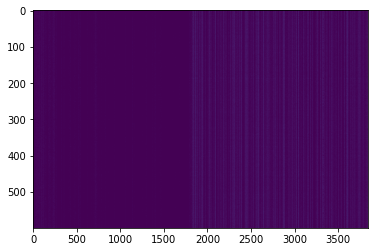

,AUC,pAUC
Source_0,0.737800,0.644211
Source_1,0.544500,0.506316
Source_2,0.652200,0.581053
Target_0,0.658100,0.616316
Target_1,0.540100,0.503158
Target_2,0.568100,0.502105
mean,0.616800,0.558860
h_mean,0.608736,0.552997


2021-05-31 23:30:56,092 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:722.124863, val_AUC_hmean:0.608736, val_pAUC_hmean:0.552997, best_flag:True
2021-05-31 23:30:56,093 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.02it/s]
2021-05-31 23:30:56,695 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 84.98it/s]
2021-05-31 23:30:56,743 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 87.83it/s]


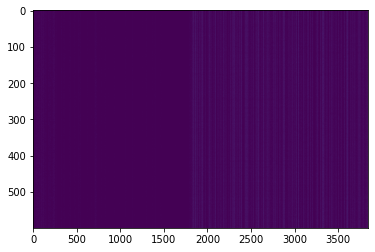

,AUC,pAUC
Source_0,0.731000,0.638421
Source_1,0.527600,0.502105
Source_2,0.700600,0.606842
Target_0,0.673800,0.647368
Target_1,0.566300,0.510526
Target_2,0.575300,0.520000
mean,0.629100,0.570877
h_mean,0.619905,0.564312


2021-05-31 23:30:58,654 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:646.958878, val_AUC_hmean:0.619905, val_pAUC_hmean:0.564312, best_flag:True
2021-05-31 23:30:58,655 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.24it/s]
2021-05-31 23:30:59,250 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 89.57it/s]
2021-05-31 23:30:59,298 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 77.56it/s]


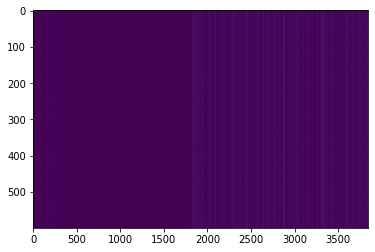

,AUC,pAUC
Source_0,0.744800,0.640000
Source_1,0.552200,0.504737
Source_2,0.693700,0.622632
Target_0,0.687300,0.640000
Target_1,0.599400,0.530526
Target_2,0.588100,0.526842
mean,0.644250,0.577456
h_mean,0.637022,0.571682


2021-05-31 23:31:01,107 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:602.357819, val_AUC_hmean:0.637022, val_pAUC_hmean:0.571682, best_flag:True
2021-05-31 23:31:01,108 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.01it/s]
2021-05-31 23:31:01,710 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 88.00it/s]
2021-05-31 23:31:01,758 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 82.10it/s]
2021-05-31 23:31:01,811 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:571.666138, val_AUC_hmean:0.628739, val_pAUC_hmean:0.570478, best_flag:False
2021-05-31 23:31:01,812 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 19.87it/s]
2021-05-31 23:31:02,418 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 76.40it/s]
2021-05-31 23:31:02,469 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 95.35it/s]
2021-05-31 23:31:02

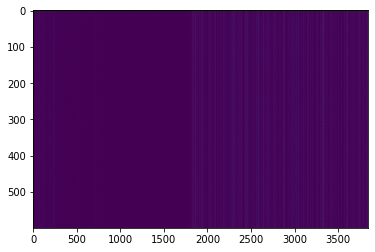

,AUC,pAUC
Source_0,0.729200,0.643684
Source_1,0.546800,0.509474
Source_2,0.711100,0.647895
Target_0,0.672700,0.638421
Target_1,0.575400,0.511579
Target_2,0.588700,0.523158
mean,0.637317,0.579035
h_mean,0.629618,0.571843


2021-05-31 23:31:05,076 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:529.003621, val_AUC_hmean:0.629618, val_pAUC_hmean:0.571843, best_flag:True
2021-05-31 23:31:05,077 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.59it/s]
2021-05-31 23:31:05,635 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 92.57it/s]
2021-05-31 23:31:05,677 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 94.14it/s]


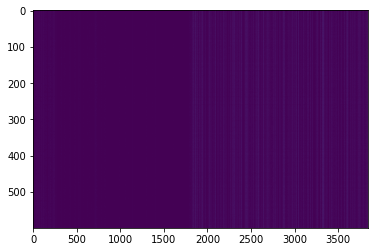

,AUC,pAUC
Source_0,0.722200,0.645789
Source_1,0.557600,0.502632
Source_2,0.696300,0.658421
Target_0,0.678100,0.643158
Target_1,0.582200,0.514737
Target_2,0.579700,0.533158
mean,0.636017,0.582982
h_mean,0.629486,0.575264


2021-05-31 23:31:07,330 - pytorch_modeler.py - INFO - epoch:10/100, train_losses:514.432228, val_AUC_hmean:0.629486, val_pAUC_hmean:0.575264, best_flag:True
2021-05-31 23:31:07,331 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 19.98it/s]
2021-05-31 23:31:07,933 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 90.73it/s]
2021-05-31 23:31:07,974 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 93.31it/s]
2021-05-31 23:31:08,018 - pytorch_modeler.py - INFO - epoch:11/100, train_losses:498.297824, val_AUC_hmean:0.628770, val_pAUC_hmean:0.573755, best_flag:False
2021-05-31 23:31:08,019 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.58it/s]
2021-05-31 23:31:08,603 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 77.07it/s]
2021-05-31 23:31:08,651 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 75.93it/s]
2021-05-31 23:31:

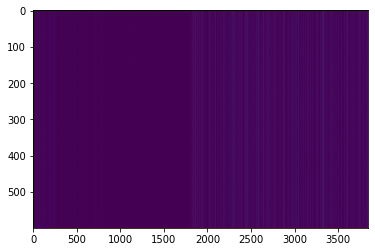

,AUC,pAUC
Source_0,0.740300,0.658421
Source_1,0.599100,0.491579
Source_2,0.713000,0.651579
Target_0,0.669600,0.661579
Target_1,0.596900,0.531579
Target_2,0.572000,0.519474
mean,0.648483,0.585702
h_mean,0.642433,0.576617


2021-05-31 23:31:11,185 - pytorch_modeler.py - INFO - epoch:13/100, train_losses:477.072184, val_AUC_hmean:0.642433, val_pAUC_hmean:0.576617, best_flag:True
2021-05-31 23:31:11,187 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.69it/s]
2021-05-31 23:31:11,743 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 92.35it/s]
2021-05-31 23:31:11,784 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 81.06it/s]
2021-05-31 23:31:11,833 - pytorch_modeler.py - INFO - epoch:14/100, train_losses:466.073893, val_AUC_hmean:0.622448, val_pAUC_hmean:0.575318, best_flag:False
2021-05-31 23:31:11,834 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.97it/s]
2021-05-31 23:31:12,408 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 81.24it/s]
2021-05-31 23:31:12,462 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 67.84it/s]
2021-05-31 23:31:

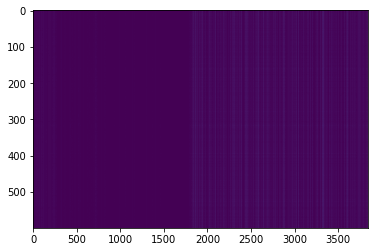

,AUC,pAUC
Source_0,0.749700,0.650000
Source_1,0.607200,0.501053
Source_2,0.712000,0.672105
Target_0,0.676700,0.664211
Target_1,0.595000,0.521053
Target_2,0.529500,0.516316
mean,0.645017,0.587456
h_mean,0.636114,0.577831


2021-05-31 23:31:17,106 - pytorch_modeler.py - INFO - epoch:18/100, train_losses:435.174967, val_AUC_hmean:0.636114, val_pAUC_hmean:0.577831, best_flag:True
2021-05-31 23:31:17,107 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.87it/s]
2021-05-31 23:31:17,975 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 46.17it/s]
2021-05-31 23:31:18,041 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 47.67it/s]
2021-05-31 23:31:18,106 - pytorch_modeler.py - INFO - epoch:19/100, train_losses:429.777878, val_AUC_hmean:0.629428, val_pAUC_hmean:0.573722, best_flag:False
2021-05-31 23:31:18,108 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.58it/s]
2021-05-31 23:31:18,993 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 84.42it/s]
2021-05-31 23:31:19,037 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 78.45it/s]
2021-05-31 23:31:

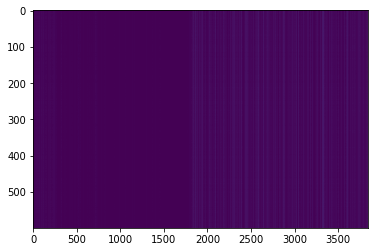

,AUC,pAUC
Source_0,0.751100,0.666316
Source_1,0.588200,0.500000
Source_2,0.745200,0.667368
Target_0,0.688700,0.661579
Target_1,0.592100,0.515789
Target_2,0.513100,0.521579
mean,0.646400,0.588772
h_mean,0.634031,0.578772


2021-05-31 23:31:21,590 - pytorch_modeler.py - INFO - epoch:21/100, train_losses:417.148259, val_AUC_hmean:0.634031, val_pAUC_hmean:0.578772, best_flag:True
2021-05-31 23:31:21,590 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.68it/s]
2021-05-31 23:31:22,470 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 74.42it/s]
2021-05-31 23:31:22,523 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 85.18it/s]


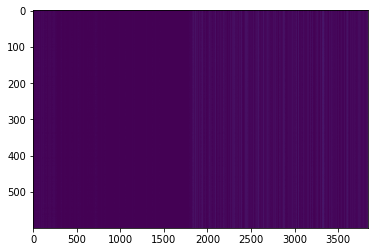

,AUC,pAUC
Source_0,0.743800,0.659474
Source_1,0.595400,0.516316
Source_2,0.753800,0.675789
Target_0,0.688400,0.657368
Target_1,0.576400,0.527895
Target_2,0.519300,0.516316
mean,0.646183,0.592193
h_mean,0.633993,0.583360


2021-05-31 23:31:24,432 - pytorch_modeler.py - INFO - epoch:22/100, train_losses:411.184354, val_AUC_hmean:0.633993, val_pAUC_hmean:0.583360, best_flag:True
2021-05-31 23:31:24,433 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 10.77it/s]
2021-05-31 23:31:25,549 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 48.58it/s]
2021-05-31 23:31:25,616 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 57.97it/s]
2021-05-31 23:31:25,674 - pytorch_modeler.py - INFO - epoch:23/100, train_losses:406.418004, val_AUC_hmean:0.629980, val_pAUC_hmean:0.572889, best_flag:False
2021-05-31 23:31:25,675 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.31it/s]
2021-05-31 23:31:26,652 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 47.13it/s]
2021-05-31 23:31:26,727 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 40.81it/s]


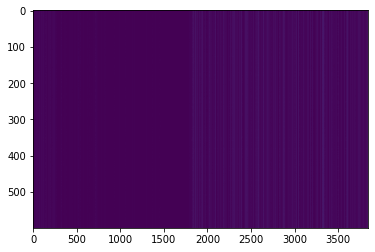

,AUC,pAUC
Source_0,0.745500,0.662632
Source_1,0.614000,0.506842
Source_2,0.741400,0.658947
Target_0,0.695000,0.668947
Target_1,0.633600,0.542632
Target_2,0.558400,0.522105
mean,0.664650,0.593684
h_mean,0.657404,0.585207


2021-05-31 23:31:28,351 - pytorch_modeler.py - INFO - epoch:24/100, train_losses:401.485703, val_AUC_hmean:0.657404, val_pAUC_hmean:0.585207, best_flag:True
2021-05-31 23:31:28,351 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.58it/s]
2021-05-31 23:31:29,307 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 75.00it/s]
2021-05-31 23:31:29,356 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 78.27it/s]
2021-05-31 23:31:29,410 - pytorch_modeler.py - INFO - epoch:25/100, train_losses:397.915975, val_AUC_hmean:0.652039, val_pAUC_hmean:0.579785, best_flag:False
2021-05-31 23:31:29,411 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.49it/s]
2021-05-31 23:31:29,999 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 72.53it/s]
2021-05-31 23:31:30,054 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 83.32it/s]
2021-05-31 23:31:

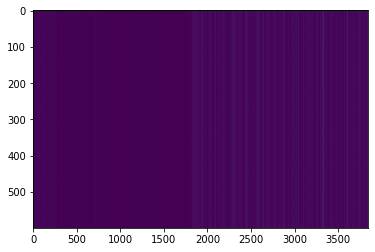

,AUC,pAUC
Source_0,0.761700,0.652632
Source_1,0.606600,0.505789
Source_2,0.767100,0.685789
Target_0,0.713500,0.660000
Target_1,0.622500,0.563158
Target_2,0.541700,0.510000
mean,0.668850,0.596228
h_mean,0.657967,0.587132


2021-05-31 23:31:37,504 - pytorch_modeler.py - INFO - epoch:33/100, train_losses:366.744021, val_AUC_hmean:0.657967, val_pAUC_hmean:0.587132, best_flag:True
2021-05-31 23:31:37,505 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.45it/s]
2021-05-31 23:31:38,470 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 47.02it/s]
2021-05-31 23:31:38,534 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 44.87it/s]
2021-05-31 23:31:38,601 - pytorch_modeler.py - INFO - epoch:34/100, train_losses:363.294421, val_AUC_hmean:0.646783, val_pAUC_hmean:0.583194, best_flag:False
2021-05-31 23:31:38,603 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.11it/s]
2021-05-31 23:31:39,596 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 67.02it/s]
2021-05-31 23:31:39,651 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 48.04it/s]
2021-05-31 23:31:

100%|██████████| 2/2 [00:00<00:00, 70.74it/s]
2021-05-31 23:31:55,339 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 57.25it/s]
2021-05-31 23:31:55,408 - pytorch_modeler.py - INFO - epoch:50/100, train_losses:320.205472, val_AUC_hmean:0.642990, val_pAUC_hmean:0.581045, best_flag:False
2021-05-31 23:31:55,409 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.23it/s]
2021-05-31 23:31:56,392 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 62.03it/s]
2021-05-31 23:31:56,443 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 50.08it/s]
2021-05-31 23:31:56,508 - pytorch_modeler.py - INFO - epoch:51/100, train_losses:317.396673, val_AUC_hmean:0.643375, val_pAUC_hmean:0.581406, best_flag:False
2021-05-31 23:31:56,509 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.17it/s]
2021-05-31 23:31:57,497 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

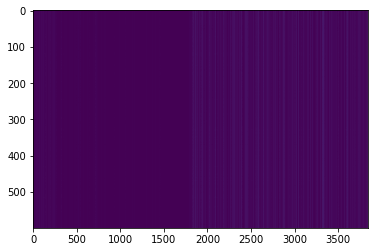

,AUC,pAUC
Source_0,0.758300,0.658421
Source_1,0.604600,0.512632
Source_2,0.794900,0.682632
Target_0,0.701500,0.663158
Target_1,0.602200,0.548421
Target_2,0.525600,0.512632
mean,0.664517,0.596316
h_mean,0.650800,0.587286


2021-05-31 23:32:07,886 - pytorch_modeler.py - INFO - epoch:60/100, train_losses:297.322479, val_AUC_hmean:0.650800, val_pAUC_hmean:0.587286, best_flag:True
2021-05-31 23:32:07,887 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.50it/s]
2021-05-31 23:32:08,850 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 48.96it/s]
2021-05-31 23:32:08,909 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 53.20it/s]
2021-05-31 23:32:08,969 - pytorch_modeler.py - INFO - epoch:61/100, train_losses:294.357463, val_AUC_hmean:0.646513, val_pAUC_hmean:0.580409, best_flag:False
2021-05-31 23:32:08,970 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.39it/s]
2021-05-31 23:32:09,941 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 90.87it/s]
2021-05-31 23:32:09,981 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 75.45it/s]
2021-05-31 23:32:

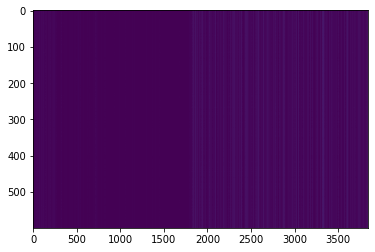

,AUC,pAUC
Source_0,0.75610,0.658421
Source_1,0.61860,0.511053
Source_2,0.77910,0.687895
Target_0,0.71040,0.661579
Target_1,0.62310,0.556316
Target_2,0.53720,0.516842
mean,0.67075,0.598684
h_mean,0.65958,0.589788


2021-05-31 23:32:22,241 - pytorch_modeler.py - INFO - epoch:73/100, train_losses:269.839574, val_AUC_hmean:0.659580, val_pAUC_hmean:0.589788, best_flag:True
2021-05-31 23:32:22,242 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.68it/s]
2021-05-31 23:32:23,272 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 66.68it/s]
2021-05-31 23:32:23,322 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 59.33it/s]
2021-05-31 23:32:23,380 - pytorch_modeler.py - INFO - epoch:74/100, train_losses:267.598094, val_AUC_hmean:0.645880, val_pAUC_hmean:0.579451, best_flag:False
2021-05-31 23:32:23,382 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.35it/s]
2021-05-31 23:32:24,356 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 73.82it/s]
2021-05-31 23:32:24,403 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 51.20it/s]
2021-05-31 23:32:

100%|██████████| 2/2 [00:00<00:00, 44.66it/s]
2021-05-31 23:32:41,639 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 46.17it/s]
2021-05-31 23:32:41,705 - pytorch_modeler.py - INFO - epoch:90/100, train_losses:238.568540, val_AUC_hmean:0.646832, val_pAUC_hmean:0.575581, best_flag:False
2021-05-31 23:32:41,706 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.65it/s]
2021-05-31 23:32:42,738 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 43.98it/s]
2021-05-31 23:32:42,817 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 45.53it/s]
2021-05-31 23:32:42,899 - pytorch_modeler.py - INFO - epoch:91/100, train_losses:236.384037, val_AUC_hmean:0.650686, val_pAUC_hmean:0.579385, best_flag:False
2021-05-31 23:32:42,900 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.69it/s]
2021-05-31 23:32:43,931 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

,AUC,pAUC
Source_0,0.75610,0.658421
Source_1,0.61860,0.511053
Source_2,0.77910,0.687895
Target_0,0.71040,0.661579
Target_1,0.62310,0.556316
Target_2,0.53720,0.516842
mean,0.67075,0.598684
h_mean,0.65958,0.589788


2021-05-31 23:32:52,886 - 00_train.py - INFO - TARGET MACHINE_TYPE: gearbox
2021-05-31 23:32:52,886 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-31 23:32:52,999 - 00_train.py - INFO - TRAINING


elapsed time: 134.680891275 [sec]


2021-05-31 23:32:53,424 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:01<00:00, 11.80it/s]
2021-05-31 23:32:54,443 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 49.25it/s]
2021-05-31 23:32:54,502 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 55.70it/s]


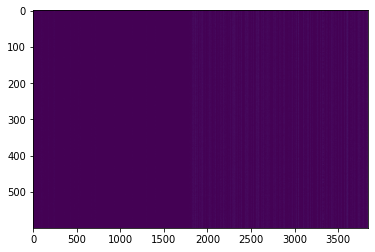

,AUC,pAUC
Source_0,0.630800,0.605263
Source_1,0.483900,0.493158
Source_2,0.381500,0.485263
Target_0,0.589300,0.565263
Target_1,0.476300,0.482105
Target_2,0.510300,0.490526
mean,0.512017,0.520263
h_mean,0.498789,0.516235


2021-05-31 23:32:56,019 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:1396.277802, val_AUC_hmean:0.498789, val_pAUC_hmean:0.516235, best_flag:True
2021-05-31 23:32:56,020 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 10.87it/s]
2021-05-31 23:32:57,126 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 64.49it/s]
2021-05-31 23:32:57,175 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 47.94it/s]


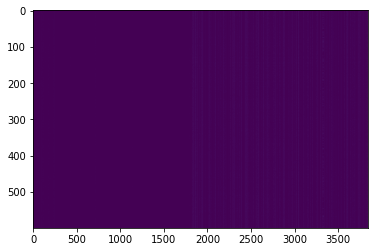

,AUC,pAUC
Source_0,0.659400,0.597895
Source_1,0.499200,0.502105
Source_2,0.460400,0.487368
Target_0,0.608900,0.589474
Target_1,0.519200,0.490526
Target_2,0.555800,0.503684
mean,0.550483,0.528509
h_mean,0.542529,0.524640


2021-05-31 23:32:58,710 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:1004.816305, val_AUC_hmean:0.542529, val_pAUC_hmean:0.524640, best_flag:True
2021-05-31 23:32:58,711 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.75it/s]
2021-05-31 23:32:59,654 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 48.46it/s]
2021-05-31 23:32:59,715 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 50.80it/s]


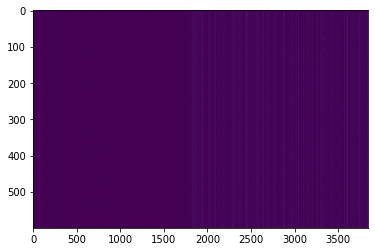

,AUC,pAUC
Source_0,0.682600,0.596842
Source_1,0.510600,0.506842
Source_2,0.574400,0.494211
Target_0,0.627500,0.604211
Target_1,0.523500,0.491579
Target_2,0.555400,0.498947
mean,0.579000,0.532105
h_mean,0.573134,0.527916


2021-05-31 23:33:01,248 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:810.533859, val_AUC_hmean:0.573134, val_pAUC_hmean:0.527916, best_flag:True
2021-05-31 23:33:01,249 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.94it/s]
2021-05-31 23:33:01,825 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 94.23it/s]
2021-05-31 23:33:01,865 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 88.27it/s]


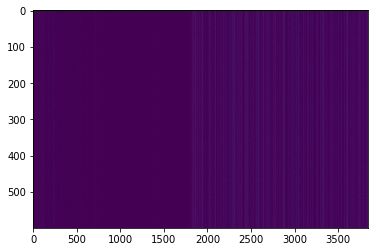

,AUC,pAUC
Source_0,0.726900,0.619474
Source_1,0.568700,0.520000
Source_2,0.659100,0.562632
Target_0,0.663700,0.604737
Target_1,0.562200,0.523684
Target_2,0.598900,0.516842
mean,0.629917,0.557895
h_mean,0.624578,0.554903


2021-05-31 23:33:03,774 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:691.358266, val_AUC_hmean:0.624578, val_pAUC_hmean:0.554903, best_flag:True
2021-05-31 23:33:03,775 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.28it/s]
2021-05-31 23:33:04,841 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 61.80it/s]
2021-05-31 23:33:04,904 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 69.26it/s]


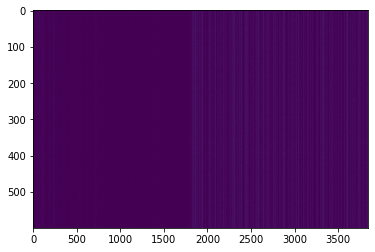

,AUC,pAUC
Source_0,0.731600,0.634737
Source_1,0.560100,0.500000
Source_2,0.708800,0.602105
Target_0,0.667000,0.634211
Target_1,0.571700,0.514211
Target_2,0.589700,0.525789
mean,0.638150,0.568509
h_mean,0.631094,0.562868


2021-05-31 23:33:06,607 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:622.166550, val_AUC_hmean:0.631094, val_pAUC_hmean:0.562868, best_flag:True
2021-05-31 23:33:06,608 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.62it/s]
2021-05-31 23:33:07,561 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 46.83it/s]
2021-05-31 23:33:07,623 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 47.46it/s]
2021-05-31 23:33:07,687 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:579.284449, val_AUC_hmean:0.636362, val_pAUC_hmean:0.556964, best_flag:False
2021-05-31 23:33:07,688 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.47it/s]
2021-05-31 23:33:08,652 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 48.00it/s]
2021-05-31 23:33:08,719 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 47.93it/s]
2021-05-31 23:33:08

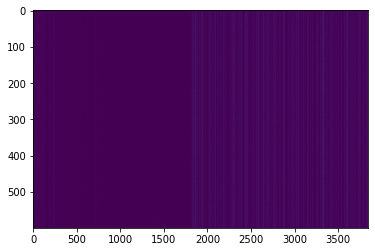

,AUC,pAUC
Source_0,0.709900,0.627368
Source_1,0.541600,0.502632
Source_2,0.699400,0.647895
Target_0,0.655300,0.626316
Target_1,0.570600,0.495789
Target_2,0.586100,0.527895
mean,0.627150,0.571316
h_mean,0.620503,0.564181


2021-05-31 23:33:11,620 - pytorch_modeler.py - INFO - epoch:8/100, train_losses:525.865412, val_AUC_hmean:0.620503, val_pAUC_hmean:0.564181, best_flag:True
2021-05-31 23:33:11,621 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.25it/s]
2021-05-31 23:33:12,689 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 44.43it/s]
2021-05-31 23:33:12,756 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 42.51it/s]


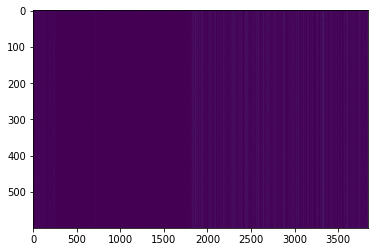

,AUC,pAUC
Source_0,0.721200,0.642105
Source_1,0.592200,0.507895
Source_2,0.711300,0.670526
Target_0,0.665900,0.641579
Target_1,0.611900,0.517368
Target_2,0.586000,0.511053
mean,0.648083,0.581754
h_mean,0.643532,0.573290


2021-05-31 23:33:14,483 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:506.606659, val_AUC_hmean:0.643532, val_pAUC_hmean:0.573290, best_flag:True
2021-05-31 23:33:14,484 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.49it/s]
2021-05-31 23:33:15,447 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 45.72it/s]
2021-05-31 23:33:15,513 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 46.13it/s]
2021-05-31 23:33:15,579 - pytorch_modeler.py - INFO - epoch:10/100, train_losses:488.923050, val_AUC_hmean:0.652339, val_pAUC_hmean:0.572427, best_flag:False
2021-05-31 23:33:15,580 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.35it/s]
2021-05-31 23:33:16,554 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 44.17it/s]
2021-05-31 23:33:16,621 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 45.44it/s]
2021-05-31 23:33:1

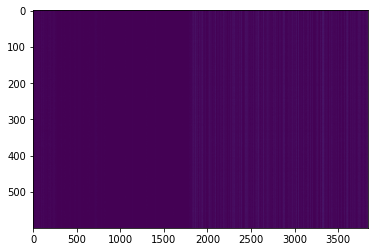

,AUC,pAUC
Source_0,0.727900,0.644211
Source_1,0.595800,0.501053
Source_2,0.743100,0.686316
Target_0,0.680800,0.637895
Target_1,0.603900,0.514211
Target_2,0.558500,0.515789
mean,0.651667,0.583246
h_mean,0.644246,0.573817


2021-05-31 23:33:20,498 - pytorch_modeler.py - INFO - epoch:13/100, train_losses:456.239848, val_AUC_hmean:0.644246, val_pAUC_hmean:0.573817, best_flag:True
2021-05-31 23:33:20,499 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.47it/s]
2021-05-31 23:33:21,464 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 45.43it/s]
2021-05-31 23:33:21,529 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 47.42it/s]


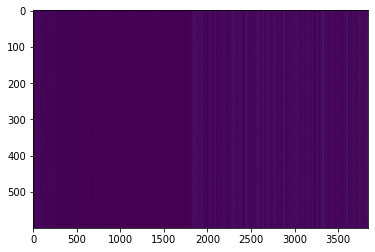

,AUC,pAUC
Source_0,0.742000,0.664737
Source_1,0.606700,0.518421
Source_2,0.737000,0.655789
Target_0,0.681200,0.647895
Target_1,0.607900,0.516316
Target_2,0.532900,0.521579
mean,0.651283,0.587456
h_mean,0.642237,0.579392


2021-05-31 23:33:23,123 - pytorch_modeler.py - INFO - epoch:14/100, train_losses:443.942139, val_AUC_hmean:0.642237, val_pAUC_hmean:0.579392, best_flag:True
2021-05-31 23:33:23,124 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.53it/s]
2021-05-31 23:33:24,167 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 49.73it/s]
2021-05-31 23:33:24,230 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 84.35it/s]
2021-05-31 23:33:24,285 - pytorch_modeler.py - INFO - epoch:15/100, train_losses:435.789452, val_AUC_hmean:0.644884, val_pAUC_hmean:0.574429, best_flag:False
2021-05-31 23:33:24,287 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.67it/s]
2021-05-31 23:33:25,317 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 51.40it/s]
2021-05-31 23:33:25,379 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 44.33it/s]
2021-05-31 23:33:

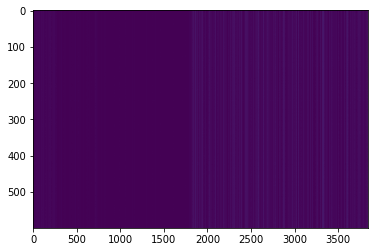

,AUC,pAUC
Source_0,0.739000,0.662632
Source_1,0.579100,0.507368
Source_2,0.783800,0.683158
Target_0,0.700300,0.651579
Target_1,0.612900,0.512632
Target_2,0.547300,0.520526
mean,0.660400,0.589649
h_mean,0.649173,0.579684


2021-05-31 23:33:32,215 - pytorch_modeler.py - INFO - epoch:21/100, train_losses:396.231964, val_AUC_hmean:0.649173, val_pAUC_hmean:0.579684, best_flag:True
2021-05-31 23:33:32,217 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.94it/s]
2021-05-31 23:33:33,080 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 85.48it/s]
2021-05-31 23:33:33,122 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 90.93it/s]
2021-05-31 23:33:33,170 - pytorch_modeler.py - INFO - epoch:22/100, train_losses:391.127223, val_AUC_hmean:0.632227, val_pAUC_hmean:0.571107, best_flag:False
2021-05-31 23:33:33,172 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.58it/s]
2021-05-31 23:33:33,757 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 90.37it/s]
2021-05-31 23:33:33,800 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 83.12it/s]
2021-05-31 23:33:

100%|██████████| 2/2 [00:00<00:00, 88.89it/s]
2021-05-31 23:33:46,087 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 74.63it/s]
2021-05-31 23:33:46,138 - pytorch_modeler.py - INFO - epoch:38/100, train_losses:332.751506, val_AUC_hmean:0.649257, val_pAUC_hmean:0.571392, best_flag:False
2021-05-31 23:33:46,139 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.55it/s]
2021-05-31 23:33:46,913 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 44.91it/s]
2021-05-31 23:33:46,988 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 51.19it/s]
2021-05-31 23:33:47,063 - pytorch_modeler.py - INFO - epoch:39/100, train_losses:329.752136, val_AUC_hmean:0.640508, val_pAUC_hmean:0.569351, best_flag:False
2021-05-31 23:33:47,064 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.28it/s]
2021-05-31 23:33:48,044 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

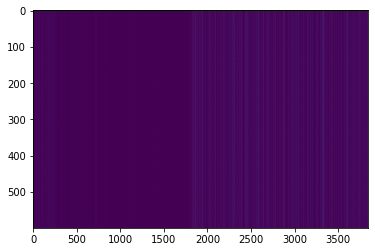

,AUC,pAUC
Source_0,0.735300,0.669474
Source_1,0.617900,0.512632
Source_2,0.795800,0.670000
Target_0,0.707800,0.652105
Target_1,0.628600,0.527368
Target_2,0.554400,0.507895
mean,0.673300,0.589912
h_mean,0.663542,0.580519


2021-05-31 23:33:50,788 - pytorch_modeler.py - INFO - epoch:41/100, train_losses:324.611216, val_AUC_hmean:0.663542, val_pAUC_hmean:0.580519, best_flag:True
2021-05-31 23:33:50,789 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 12.00it/s]
2021-05-31 23:33:51,792 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 53.62it/s]
2021-05-31 23:33:51,856 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 83.51it/s]
2021-05-31 23:33:51,904 - pytorch_modeler.py - INFO - epoch:42/100, train_losses:322.080015, val_AUC_hmean:0.648595, val_pAUC_hmean:0.577035, best_flag:False
2021-05-31 23:33:51,905 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.45it/s]
2021-05-31 23:33:52,494 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 82.32it/s]
2021-05-31 23:33:52,542 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 80.30it/s]
2021-05-31 23:33:

100%|██████████| 2/2 [00:00<00:00, 71.07it/s]
2021-05-31 23:34:04,569 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 81.58it/s]
2021-05-31 23:34:04,617 - pytorch_modeler.py - INFO - epoch:58/100, train_losses:284.615898, val_AUC_hmean:0.655268, val_pAUC_hmean:0.577407, best_flag:False
2021-05-31 23:34:04,618 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.48it/s]
2021-05-31 23:34:05,206 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 46.63it/s]
2021-05-31 23:34:05,268 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 77.12it/s]
2021-05-31 23:34:05,315 - pytorch_modeler.py - INFO - epoch:59/100, train_losses:281.325803, val_AUC_hmean:0.647493, val_pAUC_hmean:0.577286, best_flag:False
2021-05-31 23:34:05,316 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.80it/s]
2021-05-31 23:34:06,334 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

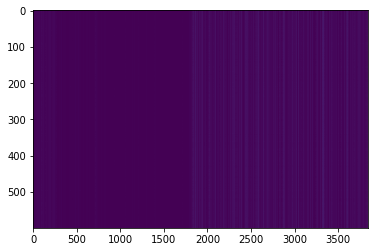

,AUC,pAUC
Source_0,0.764200,0.683158
Source_1,0.602400,0.506842
Source_2,0.816400,0.670526
Target_0,0.692900,0.654737
Target_1,0.613400,0.522105
Target_2,0.543300,0.511579
mean,0.672100,0.591491
h_mean,0.658794,0.581083


2021-05-31 23:34:18,132 - pytorch_modeler.py - INFO - epoch:73/100, train_losses:253.032518, val_AUC_hmean:0.658794, val_pAUC_hmean:0.581083, best_flag:True
2021-05-31 23:34:18,133 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.52it/s]
2021-05-31 23:34:19,093 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 52.35it/s]
2021-05-31 23:34:19,152 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 50.26it/s]
2021-05-31 23:34:19,217 - pytorch_modeler.py - INFO - epoch:74/100, train_losses:251.196916, val_AUC_hmean:0.641470, val_pAUC_hmean:0.572002, best_flag:False
2021-05-31 23:34:19,218 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.68it/s]
2021-05-31 23:34:20,247 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 82.17it/s]
2021-05-31 23:34:20,294 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 93.61it/s]
2021-05-31 23:34:

100%|██████████| 2/2 [00:00<00:00, 69.81it/s]
2021-05-31 23:34:35,241 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 50.44it/s]
2021-05-31 23:34:35,304 - pytorch_modeler.py - INFO - epoch:90/100, train_losses:222.475772, val_AUC_hmean:0.647285, val_pAUC_hmean:0.570260, best_flag:False
2021-05-31 23:34:35,304 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.94it/s]
2021-05-31 23:34:36,312 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 69.28it/s]
2021-05-31 23:34:36,364 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 78.05it/s]
2021-05-31 23:34:36,411 - pytorch_modeler.py - INFO - epoch:91/100, train_losses:220.995187, val_AUC_hmean:0.645455, val_pAUC_hmean:0.568715, best_flag:False
2021-05-31 23:34:36,412 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.97it/s]
2021-05-31 23:34:37,417 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

,AUC,pAUC
Source_0,0.764200,0.683158
Source_1,0.602400,0.506842
Source_2,0.816400,0.670526
Target_0,0.692900,0.654737
Target_1,0.613400,0.522105
Target_2,0.543300,0.511579
mean,0.672100,0.591491
h_mean,0.658794,0.581083


2021-05-31 23:34:45,369 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2021-05-31 23:34:45,370 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-31 23:34:45,371 - 00_train.py - INFO - TRAINING


elapsed time: 112.482545376 [sec]


2021-05-31 23:34:45,806 - pytorch_modeler.py - INFO - train
 17%|█▋        | 2/12 [00:00<00:00, 18.97it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 20.39it/s]
2021-05-31 23:34:46,397 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 77.31it/s]
2021-05-31 23:34:46,446 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 79.09it/s]


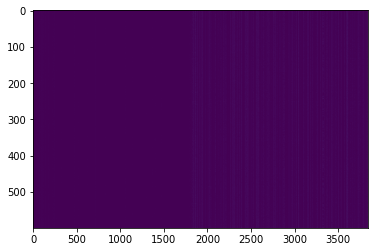

,AUC,pAUC
Source_0,0.620500,0.583684
Source_1,0.511300,0.495789
Source_2,0.402800,0.501053
Target_0,0.587900,0.554737
Target_1,0.516500,0.496316
Target_2,0.478450,0.490526
mean,0.519575,0.520351
h_mean,0.509460,0.518038


2021-05-31 23:34:48,497 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:1419.862000, val_AUC_hmean:0.509460, val_pAUC_hmean:0.518038, best_flag:True
2021-05-31 23:34:48,498 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.34it/s]
2021-05-31 23:34:49,558 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 78.05it/s]
2021-05-31 23:34:49,605 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 46.08it/s]


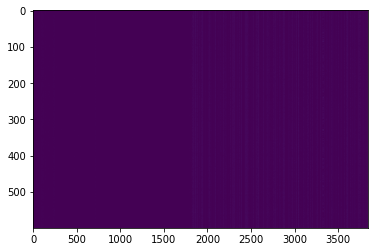

,AUC,pAUC
Source_0,0.660700,0.596316
Source_1,0.494200,0.500000
Source_2,0.476200,0.492632
Target_0,0.604500,0.587368
Target_1,0.483200,0.487368
Target_2,0.505100,0.497368
mean,0.537317,0.526842
h_mean,0.529074,0.523021


2021-05-31 23:34:51,334 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:1043.375554, val_AUC_hmean:0.529074, val_pAUC_hmean:0.523021, best_flag:True
2021-05-31 23:34:51,335 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.61it/s]
2021-05-31 23:34:52,289 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 41.67it/s]
2021-05-31 23:34:52,360 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 43.77it/s]


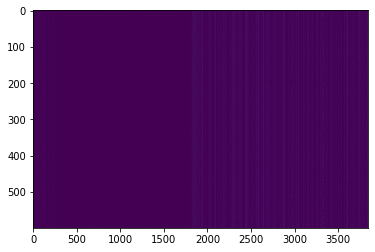

,AUC,pAUC
Source_0,0.690200,0.591579
Source_1,0.509600,0.507895
Source_2,0.555100,0.500000
Target_0,0.627800,0.615263
Target_1,0.508800,0.489474
Target_2,0.532000,0.499474
mean,0.570583,0.533947
h_mean,0.563347,0.529580


2021-05-31 23:34:53,962 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:841.235041, val_AUC_hmean:0.563347, val_pAUC_hmean:0.529580, best_flag:True
2021-05-31 23:34:53,963 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.18it/s]
2021-05-31 23:34:54,560 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 87.27it/s]
2021-05-31 23:34:54,607 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 83.40it/s]


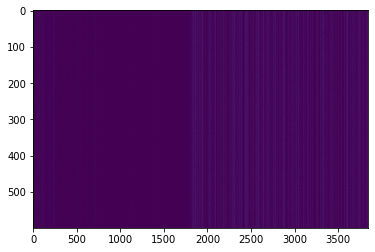

,AUC,pAUC
Source_0,0.744800,0.621053
Source_1,0.546700,0.504211
Source_2,0.639000,0.552105
Target_0,0.666500,0.609474
Target_1,0.566500,0.519474
Target_2,0.576100,0.503158
mean,0.623267,0.551579
h_mean,0.616133,0.547548


2021-05-31 23:34:56,562 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:718.804138, val_AUC_hmean:0.616133, val_pAUC_hmean:0.547548, best_flag:True
2021-05-31 23:34:56,563 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.12it/s]
2021-05-31 23:34:57,644 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 43.38it/s]
2021-05-31 23:34:57,716 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 45.89it/s]


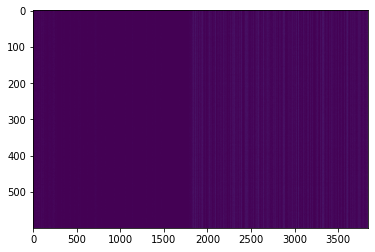

,AUC,pAUC
Source_0,0.746800,0.628947
Source_1,0.567400,0.498947
Source_2,0.695500,0.609474
Target_0,0.669100,0.615789
Target_1,0.577600,0.528421
Target_2,0.581300,0.511579
mean,0.639617,0.565526
h_mean,0.632550,0.560432


2021-05-31 23:34:59,448 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:646.440582, val_AUC_hmean:0.632550, val_pAUC_hmean:0.560432, best_flag:True
2021-05-31 23:34:59,450 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 18.88it/s]
2021-05-31 23:35:00,088 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 84.65it/s]
2021-05-31 23:35:00,131 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 70.67it/s]


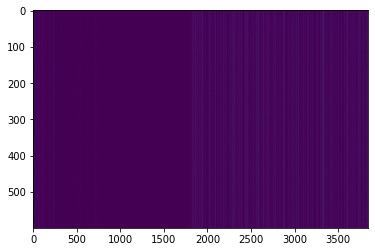

,AUC,pAUC
Source_0,0.729800,0.635789
Source_1,0.527000,0.493158
Source_2,0.687600,0.611053
Target_0,0.672600,0.649474
Target_1,0.594900,0.528421
Target_2,0.600300,0.524737
mean,0.635367,0.573772
h_mean,0.627900,0.567377


2021-05-31 23:35:02,220 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:601.725423, val_AUC_hmean:0.627900, val_pAUC_hmean:0.567377, best_flag:True
2021-05-31 23:35:02,222 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.61it/s]
2021-05-31 23:35:03,257 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.60it/s]
2021-05-31 23:35:03,316 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 72.86it/s]
2021-05-31 23:35:03,370 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:569.720891, val_AUC_hmean:0.632797, val_pAUC_hmean:0.558963, best_flag:False
2021-05-31 23:35:03,371 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.23it/s]
2021-05-31 23:35:04,442 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 44.48it/s]
2021-05-31 23:35:04,508 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 68.89it/s]
2021-05-31 23:35:04

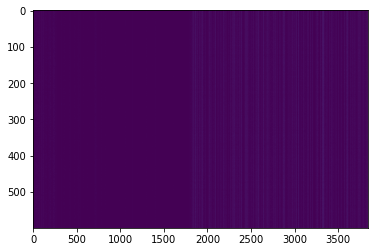

,AUC,pAUC
Source_0,0.727000,0.658421
Source_1,0.551000,0.500526
Source_2,0.699900,0.656316
Target_0,0.645300,0.650526
Target_1,0.556300,0.508947
Target_2,0.566300,0.516842
mean,0.624300,0.581930
h_mean,0.616505,0.572671


2021-05-31 23:35:07,301 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:528.274907, val_AUC_hmean:0.616505, val_pAUC_hmean:0.572671, best_flag:True
2021-05-31 23:35:07,302 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.11it/s]
2021-05-31 23:35:08,296 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 56.52it/s]
2021-05-31 23:35:08,357 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 56.16it/s]
2021-05-31 23:35:08,420 - pytorch_modeler.py - INFO - epoch:10/100, train_losses:511.665916, val_AUC_hmean:0.624364, val_pAUC_hmean:0.571011, best_flag:False
2021-05-31 23:35:08,421 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.43it/s]
2021-05-31 23:35:09,473 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 64.87it/s]
2021-05-31 23:35:09,529 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 79.03it/s]


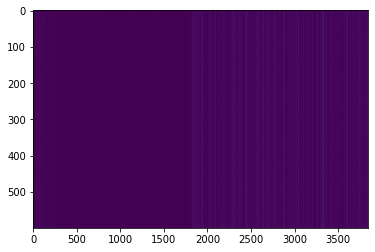

,AUC,pAUC
Source_0,0.734000,0.650000
Source_1,0.609200,0.495789
Source_2,0.706600,0.642105
Target_0,0.661600,0.667895
Target_1,0.622100,0.532105
Target_2,0.608300,0.526316
mean,0.656967,0.585702
h_mean,0.653453,0.577512


2021-05-31 23:35:11,340 - pytorch_modeler.py - INFO - epoch:11/100, train_losses:497.814512, val_AUC_hmean:0.653453, val_pAUC_hmean:0.577512, best_flag:True
2021-05-31 23:35:11,341 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.47it/s]
2021-05-31 23:35:12,390 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 47.92it/s]
2021-05-31 23:35:12,453 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 44.79it/s]
2021-05-31 23:35:12,525 - pytorch_modeler.py - INFO - epoch:12/100, train_losses:486.166931, val_AUC_hmean:0.622634, val_pAUC_hmean:0.568307, best_flag:False
2021-05-31 23:35:12,526 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.24it/s]
2021-05-31 23:35:13,509 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 47.76it/s]
2021-05-31 23:35:13,571 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 45.82it/s]
2021-05-31 23:35:

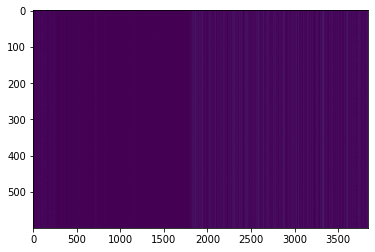

,AUC,pAUC
Source_0,0.731800,0.650526
Source_1,0.560700,0.494737
Source_2,0.757500,0.700526
Target_0,0.692300,0.661579
Target_1,0.598600,0.510526
Target_2,0.527200,0.518421
mean,0.644683,0.589386
h_mean,0.632781,0.577744


2021-05-31 23:35:23,356 - pytorch_modeler.py - INFO - epoch:20/100, train_losses:421.479299, val_AUC_hmean:0.632781, val_pAUC_hmean:0.577744, best_flag:True
2021-05-31 23:35:23,357 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.57it/s]
2021-05-31 23:35:24,397 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 48.48it/s]
2021-05-31 23:35:24,458 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 51.63it/s]
2021-05-31 23:35:24,517 - pytorch_modeler.py - INFO - epoch:21/100, train_losses:415.702685, val_AUC_hmean:0.619638, val_pAUC_hmean:0.573374, best_flag:False
2021-05-31 23:35:24,518 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.60it/s]
2021-05-31 23:35:25,473 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 46.53it/s]
2021-05-31 23:35:25,535 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 74.76it/s]


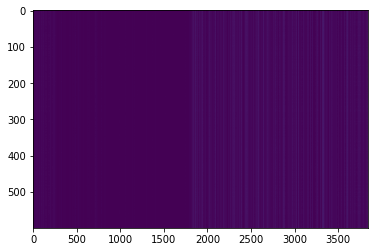

,AUC,pAUC
Source_0,0.738700,0.652632
Source_1,0.581100,0.504211
Source_2,0.762800,0.688947
Target_0,0.687300,0.662632
Target_1,0.618900,0.523158
Target_2,0.549100,0.515789
mean,0.656317,0.591228
h_mean,0.646728,0.581034


2021-05-31 23:35:27,183 - pytorch_modeler.py - INFO - epoch:22/100, train_losses:409.793803, val_AUC_hmean:0.646728, val_pAUC_hmean:0.581034, best_flag:True
2021-05-31 23:35:27,184 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.08it/s]
2021-05-31 23:35:28,180 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 73.51it/s]
2021-05-31 23:35:28,230 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 56.94it/s]
2021-05-31 23:35:28,289 - pytorch_modeler.py - INFO - epoch:23/100, train_losses:405.170764, val_AUC_hmean:0.635467, val_pAUC_hmean:0.571272, best_flag:False
2021-05-31 23:35:28,290 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.54it/s]
2021-05-31 23:35:29,332 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 48.69it/s]
2021-05-31 23:35:29,393 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 43.20it/s]
2021-05-31 23:35:

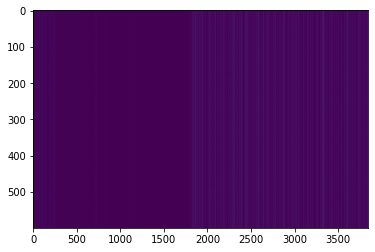

,AUC,pAUC
Source_0,0.750200,0.657368
Source_1,0.602900,0.503684
Source_2,0.762300,0.692632
Target_0,0.696000,0.660000
Target_1,0.601400,0.531053
Target_2,0.549500,0.515263
mean,0.660383,0.593333
h_mean,0.650558,0.583129


2021-05-31 23:35:36,304 - pytorch_modeler.py - INFO - epoch:30/100, train_losses:374.465182, val_AUC_hmean:0.650558, val_pAUC_hmean:0.583129, best_flag:True
2021-05-31 23:35:36,305 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.97it/s]
2021-05-31 23:35:37,233 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 48.23it/s]
2021-05-31 23:35:37,294 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 59.64it/s]
2021-05-31 23:35:37,348 - pytorch_modeler.py - INFO - epoch:31/100, train_losses:372.902412, val_AUC_hmean:0.639604, val_pAUC_hmean:0.578419, best_flag:False
2021-05-31 23:35:37,349 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.09it/s]
2021-05-31 23:35:38,344 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 44.73it/s]
2021-05-31 23:35:38,412 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 64.28it/s]
2021-05-31 23:35:

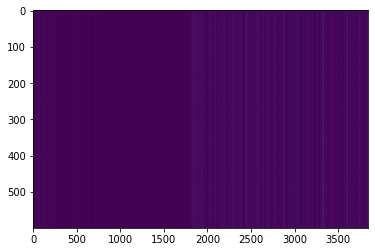

,AUC,pAUC
Source_0,0.748300,0.653158
Source_1,0.612400,0.505789
Source_2,0.777600,0.688421
Target_0,0.712900,0.659474
Target_1,0.639200,0.543158
Target_2,0.569400,0.518421
mean,0.676633,0.594737
h_mean,0.668248,0.585531


2021-05-31 23:35:49,075 - pytorch_modeler.py - INFO - epoch:40/100, train_losses:344.648109, val_AUC_hmean:0.668248, val_pAUC_hmean:0.585531, best_flag:True
2021-05-31 23:35:49,076 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.35it/s]
2021-05-31 23:35:50,136 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.07it/s]
2021-05-31 23:35:50,197 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 65.38it/s]
2021-05-31 23:35:50,253 - pytorch_modeler.py - INFO - epoch:41/100, train_losses:341.488230, val_AUC_hmean:0.633736, val_pAUC_hmean:0.576516, best_flag:False
2021-05-31 23:35:50,254 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.44it/s]
2021-05-31 23:35:51,305 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 72.74it/s]
2021-05-31 23:35:51,353 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 47.49it/s]
2021-05-31 23:35:

100%|██████████| 2/2 [00:00<00:00, 48.31it/s]
2021-05-31 23:36:06,733 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 76.85it/s]
2021-05-31 23:36:06,781 - pytorch_modeler.py - INFO - epoch:57/100, train_losses:302.785042, val_AUC_hmean:0.653405, val_pAUC_hmean:0.581938, best_flag:False
2021-05-31 23:36:06,782 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.70it/s]
2021-05-31 23:36:07,728 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 46.57it/s]
2021-05-31 23:36:07,790 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 49.37it/s]
2021-05-31 23:36:07,852 - pytorch_modeler.py - INFO - epoch:58/100, train_losses:300.971390, val_AUC_hmean:0.638152, val_pAUC_hmean:0.579858, best_flag:False
2021-05-31 23:36:07,853 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.84it/s]
2021-05-31 23:36:08,868 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 12.41it/s]
2021-05-31 23:36:25,519 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 76.70it/s]
2021-05-31 23:36:25,563 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 51.41it/s]
2021-05-31 23:36:25,625 - pytorch_modeler.py - INFO - epoch:74/100, train_losses:268.132734, val_AUC_hmean:0.655176, val_pAUC_hmean:0.580835, best_flag:False
2021-05-31 23:36:25,626 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 16.79it/s]
2021-05-31 23:36:26,342 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 90.27it/s]
2021-05-31 23:36:26,383 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 93.66it/s]
2021-05-31 23:36:26,425 - pytorch_modeler.py - INFO - epoch:75/100, train_losses:265.706502, val_AUC_hmean:0.637945, val_pAUC_hmean:0.577161, best_flag:False
2021-05-31 23:36:26,426 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-31 23:36:38,911 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.96it/s]
2021-05-31 23:36:39,838 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 47.50it/s]
2021-05-31 23:36:39,898 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 73.34it/s]
2021-05-31 23:36:39,947 - pytorch_modeler.py - INFO - epoch:91/100, train_losses:237.493243, val_AUC_hmean:0.658888, val_pAUC_hmean:0.579625, best_flag:False
2021-05-31 23:36:39,948 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.84it/s]
2021-05-31 23:36:40,964 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 63.71it/s]
2021-05-31 23:36:41,016 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 54.48it/s]
2021-05-31 23:36:41,078 - pytorch_modeler.py - INFO - epoch:92/100, train_losses:235.269004, val_AUC_hmean:0.656548, val_pAUC_hmean:0.579791, best_flag:False
2021-05-31 23:36

,AUC,pAUC
Source_0,0.748300,0.653158
Source_1,0.612400,0.505789
Source_2,0.777600,0.688421
Target_0,0.712900,0.659474
Target_1,0.639200,0.543158
Target_2,0.569400,0.518421
mean,0.676633,0.594737
h_mean,0.668248,0.585531


2021-05-31 23:36:47,551 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyTrain
2021-05-31 23:36:47,552 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-31 23:36:47,729 - 00_train.py - INFO - TRAINING


elapsed time: 122.179922104 [sec]


2021-05-31 23:36:48,137 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 12.11it/s]
2021-05-31 23:36:49,131 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 48.30it/s]
2021-05-31 23:36:49,193 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 47.47it/s]


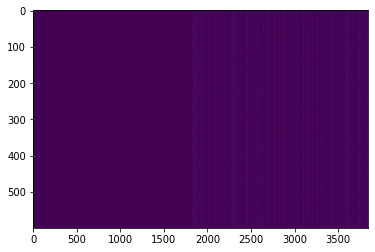

,AUC,pAUC
Source_0,0.614300,0.593684
Source_1,0.493200,0.485789
Source_2,0.404400,0.486842
Target_0,0.576000,0.567895
Target_1,0.534500,0.493684
Target_2,0.523200,0.498421
mean,0.524267,0.521053
h_mean,0.515173,0.517698


2021-05-31 23:36:51,306 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:1412.683716, val_AUC_hmean:0.515173, val_pAUC_hmean:0.517698, best_flag:True
2021-05-31 23:36:51,306 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.58it/s]
2021-05-31 23:36:51,864 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 76.52it/s]
2021-05-31 23:36:51,911 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 49.65it/s]


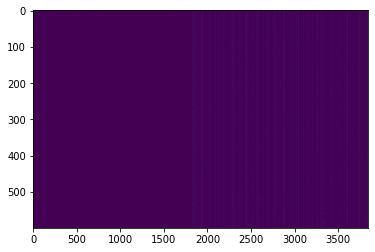

,AUC,pAUC
Source_0,0.659900,0.598947
Source_1,0.478600,0.500526
Source_2,0.488400,0.489474
Target_0,0.598700,0.596842
Target_1,0.523600,0.489474
Target_2,0.556200,0.496842
mean,0.550900,0.528684
h_mean,0.543953,0.524397


2021-05-31 23:36:53,530 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:1021.926956, val_AUC_hmean:0.543953, val_pAUC_hmean:0.524397, best_flag:True
2021-05-31 23:36:53,531 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.95it/s]
2021-05-31 23:36:54,105 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 86.26it/s]
2021-05-31 23:36:54,148 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 95.41it/s]


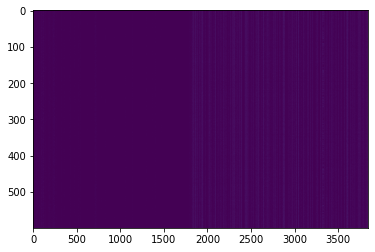

,AUC,pAUC
Source_0,0.677700,0.599474
Source_1,0.505800,0.505263
Source_2,0.578200,0.502105
Target_0,0.623900,0.605789
Target_1,0.528700,0.492105
Target_2,0.554700,0.496842
mean,0.578167,0.533596
h_mean,0.572564,0.529360


2021-05-31 23:36:56,192 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:819.152832, val_AUC_hmean:0.572564, val_pAUC_hmean:0.529360, best_flag:True
2021-05-31 23:36:56,193 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.82it/s]
2021-05-31 23:36:57,211 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 49.07it/s]
2021-05-31 23:36:57,271 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 46.47it/s]


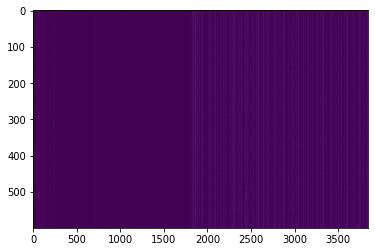

,AUC,pAUC
Source_0,0.713600,0.616316
Source_1,0.542000,0.513684
Source_2,0.643400,0.546842
Target_0,0.656100,0.615789
Target_1,0.534200,0.503158
Target_2,0.581600,0.516316
mean,0.611817,0.552018
h_mean,0.605076,0.548139


2021-05-31 23:36:59,071 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:698.885371, val_AUC_hmean:0.605076, val_pAUC_hmean:0.548139, best_flag:True
2021-05-31 23:36:59,072 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.90it/s]
2021-05-31 23:36:59,649 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 92.00it/s]
2021-05-31 23:36:59,690 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 83.71it/s]


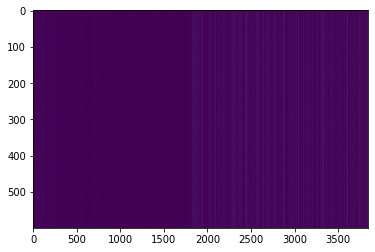

,AUC,pAUC
Source_0,0.720400,0.632632
Source_1,0.533900,0.502632
Source_2,0.665500,0.563158
Target_0,0.665600,0.630526
Target_1,0.566800,0.513158
Target_2,0.592900,0.517368
mean,0.624183,0.559912
h_mean,0.617470,0.554863


2021-05-31 23:37:01,457 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:628.910828, val_AUC_hmean:0.617470, val_pAUC_hmean:0.554863, best_flag:True
2021-05-31 23:37:01,458 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.44it/s]
2021-05-31 23:37:02,047 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 94.09it/s]
2021-05-31 23:37:02,088 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 86.82it/s]


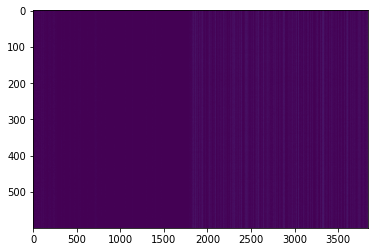

,AUC,pAUC
Source_0,0.720100,0.637895
Source_1,0.562200,0.505789
Source_2,0.687200,0.616316
Target_0,0.659800,0.638947
Target_1,0.597700,0.527368
Target_2,0.590900,0.531053
mean,0.636317,0.576228
h_mean,0.631338,0.570796


2021-05-31 23:37:04,161 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:584.924067, val_AUC_hmean:0.631338, val_pAUC_hmean:0.570796, best_flag:True
2021-05-31 23:37:04,162 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.23it/s]
2021-05-31 23:37:05,146 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 51.96it/s]
2021-05-31 23:37:05,203 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 56.05it/s]
2021-05-31 23:37:05,261 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:555.402791, val_AUC_hmean:0.640422, val_pAUC_hmean:0.570335, best_flag:False
2021-05-31 23:37:05,262 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.48it/s]
2021-05-31 23:37:06,093 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 73.62it/s]
2021-05-31 23:37:06,143 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 80.78it/s]
2021-05-31 23:37:06

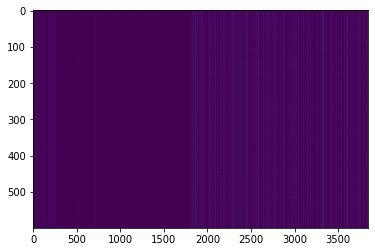

,AUC,pAUC
Source_0,0.735000,0.646842
Source_1,0.604900,0.504211
Source_2,0.718000,0.660000
Target_0,0.678400,0.652632
Target_1,0.630000,0.537895
Target_2,0.571100,0.525263
mean,0.656233,0.587807
h_mean,0.650842,0.580294


2021-05-31 23:37:09,908 - pytorch_modeler.py - INFO - epoch:11/100, train_losses:483.288900, val_AUC_hmean:0.650842, val_pAUC_hmean:0.580294, best_flag:True
2021-05-31 23:37:09,909 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.20it/s]
2021-05-31 23:37:10,982 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 61.21it/s]
2021-05-31 23:37:11,033 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 51.70it/s]
2021-05-31 23:37:11,097 - pytorch_modeler.py - INFO - epoch:12/100, train_losses:471.428195, val_AUC_hmean:0.637200, val_pAUC_hmean:0.574179, best_flag:False
2021-05-31 23:37:11,098 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.59it/s]
2021-05-31 23:37:12,053 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 68.72it/s]
2021-05-31 23:37:12,101 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 53.18it/s]
2021-05-31 23:37:

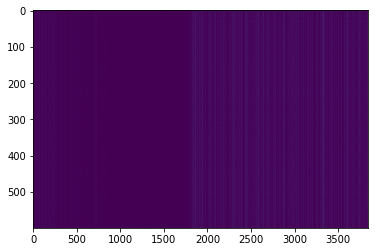

,AUC,pAUC
Source_0,0.747600,0.643684
Source_1,0.627700,0.518421
Source_2,0.754900,0.671053
Target_0,0.706500,0.654737
Target_1,0.629800,0.543158
Target_2,0.551300,0.511053
mean,0.669633,0.590351
h_mean,0.661336,0.582646


2021-05-31 23:37:22,536 - pytorch_modeler.py - INFO - epoch:22/100, train_losses:396.771477, val_AUC_hmean:0.661336, val_pAUC_hmean:0.582646, best_flag:True
2021-05-31 23:37:22,537 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.30it/s]
2021-05-31 23:37:23,102 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 92.42it/s]
2021-05-31 23:37:23,142 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 95.20it/s]
2021-05-31 23:37:23,192 - pytorch_modeler.py - INFO - epoch:23/100, train_losses:391.804558, val_AUC_hmean:0.642963, val_pAUC_hmean:0.573908, best_flag:False
2021-05-31 23:37:23,193 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 17.91it/s]
2021-05-31 23:37:23,864 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 46.91it/s]
2021-05-31 23:37:23,925 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 69.49it/s]
2021-05-31 23:37:

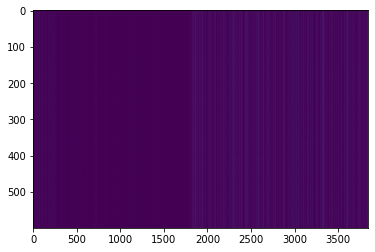

,AUC,pAUC
Source_0,0.760100,0.648947
Source_1,0.613300,0.521053
Source_2,0.777200,0.675789
Target_0,0.710700,0.662105
Target_1,0.636100,0.556316
Target_2,0.576300,0.506842
mean,0.678950,0.595175
h_mean,0.670604,0.587040


2021-05-31 23:37:38,519 - pytorch_modeler.py - INFO - epoch:36/100, train_losses:343.427116, val_AUC_hmean:0.670604, val_pAUC_hmean:0.587040, best_flag:True
2021-05-31 23:37:38,520 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.45it/s]
2021-05-31 23:37:39,486 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 64.41it/s]
2021-05-31 23:37:39,535 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 49.30it/s]
2021-05-31 23:37:39,598 - pytorch_modeler.py - INFO - epoch:37/100, train_losses:340.627360, val_AUC_hmean:0.660031, val_pAUC_hmean:0.578405, best_flag:False
2021-05-31 23:37:39,599 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.91it/s]
2021-05-31 23:37:40,608 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 93.11it/s]
2021-05-31 23:37:40,650 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 86.60it/s]
2021-05-31 23:37:

100%|██████████| 2/2 [00:00<00:00, 47.68it/s]
2021-05-31 23:37:55,723 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 76.59it/s]
2021-05-31 23:37:55,770 - pytorch_modeler.py - INFO - epoch:53/100, train_losses:299.154480, val_AUC_hmean:0.650738, val_pAUC_hmean:0.576422, best_flag:False
2021-05-31 23:37:55,771 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.61it/s]
2021-05-31 23:37:56,725 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 49.65it/s]
2021-05-31 23:37:56,793 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 60.58it/s]
2021-05-31 23:37:56,852 - pytorch_modeler.py - INFO - epoch:54/100, train_losses:296.499054, val_AUC_hmean:0.660259, val_pAUC_hmean:0.580584, best_flag:False
2021-05-31 23:37:56,853 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.82it/s]
2021-05-31 23:37:57,870 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:01<00:00, 11.33it/s]
2021-05-31 23:38:14,599 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 62.30it/s]
2021-05-31 23:38:14,653 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 43.44it/s]
2021-05-31 23:38:14,727 - pytorch_modeler.py - INFO - epoch:70/100, train_losses:262.975161, val_AUC_hmean:0.661804, val_pAUC_hmean:0.582507, best_flag:False
2021-05-31 23:38:14,728 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.33it/s]
2021-05-31 23:38:15,703 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 39.54it/s]
2021-05-31 23:38:15,778 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 61.68it/s]
2021-05-31 23:38:15,836 - pytorch_modeler.py - INFO - epoch:71/100, train_losses:260.942284, val_AUC_hmean:0.648812, val_pAUC_hmean:0.575636, best_flag:False
2021-05-31 23:38:15,838 - pytorch_modeler.py - INFO - train
100%|██████████|

2021-05-31 23:38:33,155 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.04it/s]
2021-05-31 23:38:34,154 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 63.48it/s]
2021-05-31 23:38:34,205 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 48.47it/s]
2021-05-31 23:38:34,281 - pytorch_modeler.py - INFO - epoch:87/100, train_losses:230.343661, val_AUC_hmean:0.649719, val_pAUC_hmean:0.579230, best_flag:False
2021-05-31 23:38:34,282 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.85it/s]
2021-05-31 23:38:35,296 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 70.22it/s]
2021-05-31 23:38:35,348 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 81.61it/s]
2021-05-31 23:38:35,402 - pytorch_modeler.py - INFO - epoch:88/100, train_losses:228.766945, val_AUC_hmean:0.639912, val_pAUC_hmean:0.570995, best_flag:False
2021-05-31 23:38

,AUC,pAUC
Source_0,0.760100,0.648947
Source_1,0.613300,0.521053
Source_2,0.777200,0.675789
Target_0,0.710700,0.662105
Target_1,0.636100,0.556316
Target_2,0.576300,0.506842
mean,0.678950,0.595175
h_mean,0.670604,0.587040


2021-05-31 23:38:49,007 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2021-05-31 23:38:49,008 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-31 23:38:49,011 - 00_train.py - INFO - TRAINING


elapsed time: 121.453825712 [sec]


2021-05-31 23:38:49,460 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:01<00:00, 11.78it/s]
2021-05-31 23:38:50,480 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 68.36it/s]
2021-05-31 23:38:50,532 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 74.09it/s]


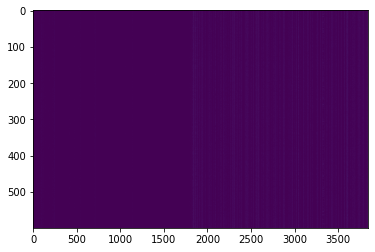

,AUC,pAUC
Source_0,0.613000,0.580000
Source_1,0.463000,0.486842
Source_2,0.362100,0.476316
Target_0,0.594000,0.558421
Target_1,0.454400,0.479474
Target_2,0.534200,0.500000
mean,0.503450,0.513509
h_mean,0.487449,0.510464


2021-05-31 23:38:52,260 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:1399.124817, val_AUC_hmean:0.487449, val_pAUC_hmean:0.510464, best_flag:True
2021-05-31 23:38:52,260 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.01it/s]
2021-05-31 23:38:53,262 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 51.35it/s]
2021-05-31 23:38:53,325 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 40.31it/s]


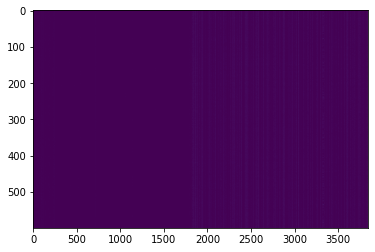

,AUC,pAUC
Source_0,0.659500,0.589474
Source_1,0.469100,0.504737
Source_2,0.492000,0.489474
Target_0,0.618100,0.580526
Target_1,0.492600,0.482105
Target_2,0.555300,0.505789
mean,0.547767,0.525351
h_mean,0.539118,0.521985


2021-05-31 23:38:55,048 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:1014.762151, val_AUC_hmean:0.539118, val_pAUC_hmean:0.521985, best_flag:True
2021-05-31 23:38:55,049 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.67it/s]
2021-05-31 23:38:55,998 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 42.70it/s]
2021-05-31 23:38:56,066 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 46.95it/s]


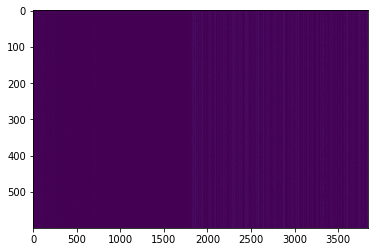

,AUC,pAUC
Source_0,0.687100,0.595263
Source_1,0.498100,0.501579
Source_2,0.577900,0.498421
Target_0,0.632800,0.604737
Target_1,0.494400,0.484211
Target_2,0.555600,0.508421
mean,0.574317,0.532105
h_mean,0.566240,0.527905


2021-05-31 23:38:57,706 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:822.779124, val_AUC_hmean:0.566240, val_pAUC_hmean:0.527905, best_flag:True
2021-05-31 23:38:57,707 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.37it/s]
2021-05-31 23:38:58,765 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 44.43it/s]
2021-05-31 23:38:58,837 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 46.65it/s]


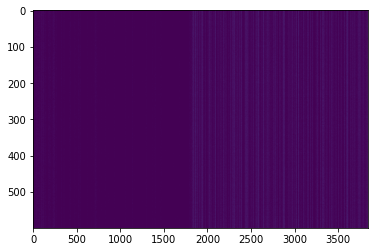

,AUC,pAUC
Source_0,0.726900,0.619474
Source_1,0.557700,0.508421
Source_2,0.656900,0.557895
Target_0,0.673400,0.616842
Target_1,0.535300,0.500526
Target_2,0.586500,0.507895
mean,0.622783,0.551842
h_mean,0.615433,0.547367


2021-05-31 23:39:00,537 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:704.165482, val_AUC_hmean:0.615433, val_pAUC_hmean:0.547367, best_flag:True
2021-05-31 23:39:00,538 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.50it/s]
2021-05-31 23:39:01,500 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 41.30it/s]
2021-05-31 23:39:01,572 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 48.30it/s]


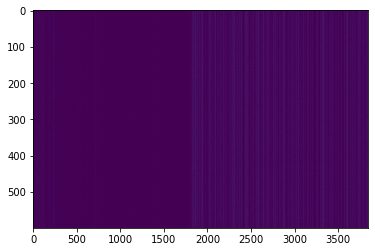

,AUC,pAUC
Source_0,0.72400,0.631053
Source_1,0.55320,0.515789
Source_2,0.67800,0.602105
Target_0,0.67420,0.632105
Target_1,0.59460,0.528421
Target_2,0.59980,0.517895
mean,0.63730,0.571228
h_mean,0.63184,0.566593


2021-05-31 23:39:03,215 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:630.286133, val_AUC_hmean:0.631840, val_pAUC_hmean:0.566593, best_flag:True
2021-05-31 23:39:03,216 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.62it/s]
2021-05-31 23:39:04,251 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 44.44it/s]
2021-05-31 23:39:04,321 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 71.69it/s]
2021-05-31 23:39:04,373 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:586.672124, val_AUC_hmean:0.618697, val_pAUC_hmean:0.562159, best_flag:False
2021-05-31 23:39:04,374 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.35it/s]
2021-05-31 23:39:05,433 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 47.27it/s]
2021-05-31 23:39:05,497 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 45.37it/s]
2021-05-31 23:39:05

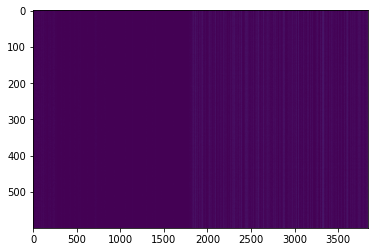

,AUC,pAUC
Source_0,0.730400,0.636842
Source_1,0.567500,0.507368
Source_2,0.696800,0.641053
Target_0,0.693300,0.646842
Target_1,0.607700,0.533684
Target_2,0.596900,0.523158
mean,0.648767,0.581491
h_mean,0.643114,0.575134


2021-05-31 23:39:08,233 - pytorch_modeler.py - INFO - epoch:8/100, train_losses:533.388997, val_AUC_hmean:0.643114, val_pAUC_hmean:0.575134, best_flag:True
2021-05-31 23:39:08,234 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 18.34it/s]
2021-05-31 23:39:08,890 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 69.40it/s]
2021-05-31 23:39:08,940 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 84.26it/s]
2021-05-31 23:39:08,990 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:513.492869, val_AUC_hmean:0.612079, val_pAUC_hmean:0.564943, best_flag:False
2021-05-31 23:39:08,991 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.05it/s]
2021-05-31 23:39:09,563 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 76.55it/s]
2021-05-31 23:39:09,608 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 77.08it/s]
2021-05-31 23:39:09

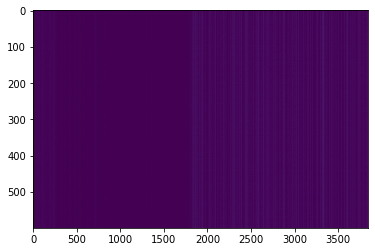

,AUC,pAUC
Source_0,0.722300,0.646316
Source_1,0.606400,0.516842
Source_2,0.709800,0.644211
Target_0,0.681800,0.663684
Target_1,0.609600,0.523684
Target_2,0.545900,0.520000
mean,0.645967,0.585789
h_mean,0.639567,0.578385


2021-05-31 23:39:13,191 - pytorch_modeler.py - INFO - epoch:12/100, train_losses:472.526827, val_AUC_hmean:0.639567, val_pAUC_hmean:0.578385, best_flag:True
2021-05-31 23:39:13,192 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.88it/s]
2021-05-31 23:39:13,769 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 77.55it/s]
2021-05-31 23:39:13,814 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 69.46it/s]
2021-05-31 23:39:13,872 - pytorch_modeler.py - INFO - epoch:13/100, train_losses:462.280764, val_AUC_hmean:0.637025, val_pAUC_hmean:0.577157, best_flag:False
2021-05-31 23:39:13,873 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 15.38it/s]
2021-05-31 23:39:14,655 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 43.51it/s]
2021-05-31 23:39:14,725 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 57.25it/s]
2021-05-31 23:39:

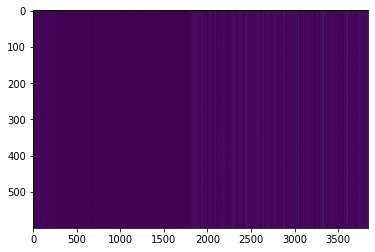

,AUC,pAUC
Source_0,0.723800,0.650526
Source_1,0.612300,0.518947
Source_2,0.744800,0.670526
Target_0,0.701100,0.671053
Target_1,0.581100,0.510000
Target_2,0.522900,0.512632
mean,0.647667,0.588947
h_mean,0.637143,0.579304


2021-05-31 23:39:25,277 - pytorch_modeler.py - INFO - epoch:24/100, train_losses:389.917600, val_AUC_hmean:0.637143, val_pAUC_hmean:0.579304, best_flag:True
2021-05-31 23:39:25,278 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.56it/s]
2021-05-31 23:39:26,165 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 55.88it/s]
2021-05-31 23:39:26,223 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 56.98it/s]
2021-05-31 23:39:26,288 - pytorch_modeler.py - INFO - epoch:25/100, train_losses:383.825717, val_AUC_hmean:0.640740, val_pAUC_hmean:0.577193, best_flag:False
2021-05-31 23:39:26,289 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 14.50it/s]
2021-05-31 23:39:27,119 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 87.75it/s]
2021-05-31 23:39:27,160 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 86.81it/s]
2021-05-31 23:39:

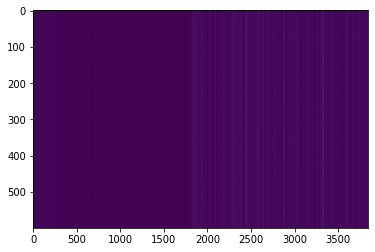

,AUC,pAUC
Source_0,0.721000,0.658421
Source_1,0.635900,0.530000
Source_2,0.752800,0.661579
Target_0,0.702000,0.673684
Target_1,0.604200,0.525263
Target_2,0.537800,0.506842
mean,0.658950,0.592632
h_mean,0.650271,0.583754


2021-05-31 23:39:33,109 - pytorch_modeler.py - INFO - epoch:31/100, train_losses:361.495590, val_AUC_hmean:0.650271, val_pAUC_hmean:0.583754, best_flag:True
2021-05-31 23:39:33,110 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.71it/s]
2021-05-31 23:39:34,137 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 60.49it/s]
2021-05-31 23:39:34,195 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 63.44it/s]
2021-05-31 23:39:34,257 - pytorch_modeler.py - INFO - epoch:32/100, train_losses:358.326909, val_AUC_hmean:0.646897, val_pAUC_hmean:0.577501, best_flag:False
2021-05-31 23:39:34,258 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.62it/s]
2021-05-31 23:39:34,842 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 87.25it/s]
2021-05-31 23:39:34,888 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 74.05it/s]
2021-05-31 23:39:

100%|██████████| 2/2 [00:00<00:00, 45.57it/s]
2021-05-31 23:39:47,917 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 72.89it/s]
2021-05-31 23:39:47,968 - pytorch_modeler.py - INFO - epoch:48/100, train_losses:312.191727, val_AUC_hmean:0.654872, val_pAUC_hmean:0.574916, best_flag:False
2021-05-31 23:39:47,969 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.68it/s]
2021-05-31 23:39:48,551 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 83.61it/s]
2021-05-31 23:39:48,595 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 79.02it/s]
2021-05-31 23:39:48,643 - pytorch_modeler.py - INFO - epoch:49/100, train_losses:309.249191, val_AUC_hmean:0.650251, val_pAUC_hmean:0.576775, best_flag:False
2021-05-31 23:39:48,645 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.37it/s]
2021-05-31 23:39:49,237 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 12.57it/s]
2021-05-31 23:40:12,844 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 43.09it/s]
2021-05-31 23:40:12,914 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 45.38it/s]


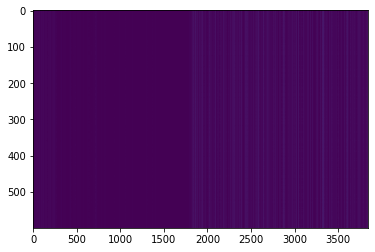

,AUC,pAUC
Source_0,0.749300,0.666842
Source_1,0.620100,0.521053
Source_2,0.780800,0.668421
Target_0,0.717900,0.669474
Target_1,0.607700,0.535263
Target_2,0.554000,0.503158
mean,0.671633,0.594035
h_mean,0.661411,0.584553


2021-05-31 23:40:14,451 - pytorch_modeler.py - INFO - epoch:65/100, train_losses:274.248416, val_AUC_hmean:0.661411, val_pAUC_hmean:0.584553, best_flag:True
2021-05-31 23:40:14,452 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.25it/s]
2021-05-31 23:40:15,434 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 69.15it/s]
2021-05-31 23:40:15,482 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 50.75it/s]
2021-05-31 23:40:15,551 - pytorch_modeler.py - INFO - epoch:66/100, train_losses:271.576352, val_AUC_hmean:0.641014, val_pAUC_hmean:0.571987, best_flag:False
2021-05-31 23:40:15,553 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.86it/s]
2021-05-31 23:40:16,567 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 51.79it/s]
2021-05-31 23:40:16,629 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 80.02it/s]
2021-05-31 23:40:

100%|██████████| 2/2 [00:00<00:00, 46.26it/s]
2021-05-31 23:40:32,170 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 74.79it/s]
2021-05-31 23:40:32,221 - pytorch_modeler.py - INFO - epoch:82/100, train_losses:241.482972, val_AUC_hmean:0.646020, val_pAUC_hmean:0.575730, best_flag:False
2021-05-31 23:40:32,222 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.37it/s]
2021-05-31 23:40:33,194 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 42.57it/s]
2021-05-31 23:40:33,263 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 72.23it/s]
2021-05-31 23:40:33,314 - pytorch_modeler.py - INFO - epoch:83/100, train_losses:239.266424, val_AUC_hmean:0.645505, val_pAUC_hmean:0.574157, best_flag:False
2021-05-31 23:40:33,316 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.64it/s]
2021-05-31 23:40:34,348 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

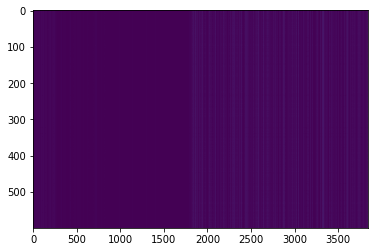

,AUC,pAUC
Source_0,0.763300,0.661053
Source_1,0.610200,0.520000
Source_2,0.779000,0.692105
Target_0,0.714100,0.661579
Target_1,0.613900,0.535789
Target_2,0.567100,0.506316
mean,0.674600,0.596140
h_mean,0.664801,0.586300


2021-05-31 23:40:51,734 - pytorch_modeler.py - INFO - epoch:98/100, train_losses:214.254744, val_AUC_hmean:0.664801, val_pAUC_hmean:0.586300, best_flag:True
2021-05-31 23:40:51,735 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.55it/s]
2021-05-31 23:40:52,693 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 44.42it/s]
2021-05-31 23:40:52,759 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 47.90it/s]
2021-05-31 23:40:52,823 - pytorch_modeler.py - INFO - epoch:99/100, train_losses:212.795633, val_AUC_hmean:0.649046, val_pAUC_hmean:0.570318, best_flag:False
2021-05-31 23:40:52,824 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.63it/s]
2021-05-31 23:40:53,776 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 45.40it/s]
2021-05-31 23:40:53,841 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 67.06it/s]
2021-05-31 23:40:

,AUC,pAUC
Source_0,0.763300,0.661053
Source_1,0.610200,0.520000
Source_2,0.779000,0.692105
Target_0,0.714100,0.661579
Target_1,0.613900,0.535789
Target_2,0.567100,0.506316
mean,0.674600,0.596140
h_mean,0.664801,0.586300


2021-05-31 23:40:53,900 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2021-05-31 23:40:53,901 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-31 23:40:53,902 - 00_train.py - INFO - TRAINING


elapsed time: 124.892038584 [sec]


2021-05-31 23:40:54,365 - pytorch_modeler.py - INFO - train
  0%|          | 0/12 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 20.33it/s]
2021-05-31 23:40:54,958 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 51.87it/s]
2021-05-31 23:40:56,511 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 50.24it/s]


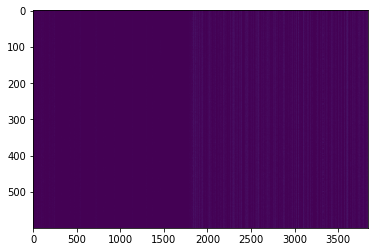

,AUC,pAUC
Source_0,0.633500,0.577368
Source_1,0.479800,0.497368
Source_2,0.373500,0.500000
Target_0,0.599400,0.560000
Target_1,0.463500,0.475263
Target_2,0.486600,0.485789
mean,0.506050,0.515965
h_mean,0.490957,0.513220


2021-05-31 23:40:58,066 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:1409.875071, val_AUC_hmean:0.490957, val_pAUC_hmean:0.513220, best_flag:True
2021-05-31 23:40:58,067 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.42it/s]
2021-05-31 23:40:59,035 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 43.35it/s]
2021-05-31 23:40:59,103 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 48.94it/s]


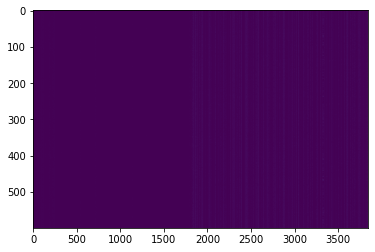

,AUC,pAUC
Source_0,0.671400,0.593158
Source_1,0.482000,0.501579
Source_2,0.372100,0.495263
Target_0,0.619400,0.591053
Target_1,0.488200,0.478947
Target_2,0.489100,0.484737
mean,0.520367,0.524123
h_mean,0.501717,0.519863


2021-05-31 23:41:00,857 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:1019.885625, val_AUC_hmean:0.501717, val_pAUC_hmean:0.519863, best_flag:True
2021-05-31 23:41:00,858 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.94it/s]
2021-05-31 23:41:01,865 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 58.47it/s]
2021-05-31 23:41:01,922 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 47.87it/s]


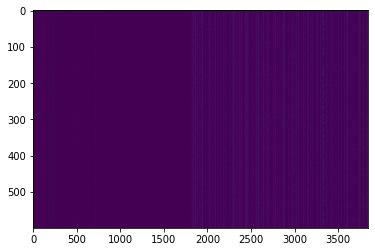

,AUC,pAUC
Source_0,0.704200,0.606316
Source_1,0.495500,0.503684
Source_2,0.538000,0.505789
Target_0,0.646500,0.608421
Target_1,0.506200,0.485263
Target_2,0.533100,0.492632
mean,0.570583,0.533684
h_mean,0.561006,0.528819


2021-05-31 23:41:03,648 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:816.577321, val_AUC_hmean:0.561006, val_pAUC_hmean:0.528819, best_flag:True
2021-05-31 23:41:03,649 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.51it/s]
2021-05-31 23:41:04,694 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 74.87it/s]
2021-05-31 23:41:04,741 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 52.88it/s]


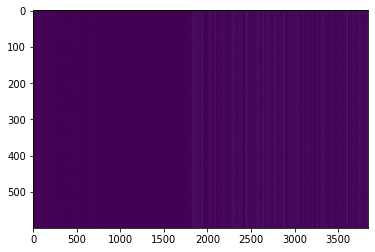

,AUC,pAUC
Source_0,0.730600,0.626316
Source_1,0.538600,0.505263
Source_2,0.644000,0.537368
Target_0,0.678200,0.626316
Target_1,0.552500,0.507895
Target_2,0.558600,0.498947
mean,0.617083,0.550351
h_mean,0.608962,0.545133


2021-05-31 23:41:06,483 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:700.340307, val_AUC_hmean:0.608962, val_pAUC_hmean:0.545133, best_flag:True
2021-05-31 23:41:06,484 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.79it/s]
2021-05-31 23:41:07,504 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 69.41it/s]
2021-05-31 23:41:07,553 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 57.04it/s]


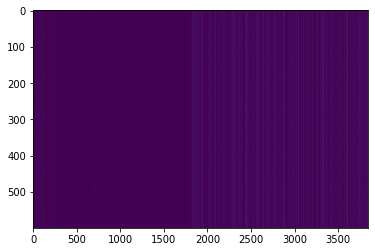

,AUC,pAUC
Source_0,0.734200,0.623684
Source_1,0.542000,0.513158
Source_2,0.650900,0.554737
Target_0,0.682900,0.628421
Target_1,0.545500,0.498947
Target_2,0.569100,0.514211
mean,0.620767,0.555526
h_mean,0.612366,0.550712


2021-05-31 23:41:09,214 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:632.848857, val_AUC_hmean:0.612366, val_pAUC_hmean:0.550712, best_flag:True
2021-05-31 23:41:09,215 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.62it/s]
2021-05-31 23:41:10,250 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 83.20it/s]
2021-05-31 23:41:10,294 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 78.31it/s]


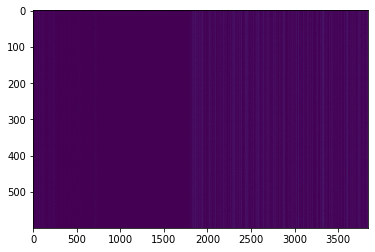

,AUC,pAUC
Source_0,0.734600,0.628421
Source_1,0.569000,0.496842
Source_2,0.687500,0.599474
Target_0,0.681400,0.638947
Target_1,0.586800,0.518421
Target_2,0.587400,0.521579
mean,0.641117,0.567281
h_mean,0.635093,0.561619


2021-05-31 23:41:11,856 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:589.392156, val_AUC_hmean:0.635093, val_pAUC_hmean:0.561619, best_flag:True
2021-05-31 23:41:11,857 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.15it/s]
2021-05-31 23:41:12,847 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 48.21it/s]
2021-05-31 23:41:12,910 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 49.71it/s]


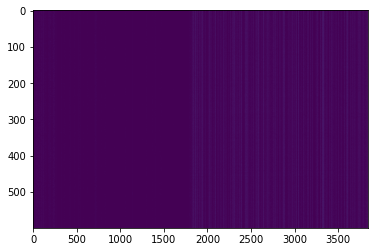

,AUC,pAUC
Source_0,0.731900,0.634211
Source_1,0.564800,0.503684
Source_2,0.702800,0.614737
Target_0,0.694900,0.647368
Target_1,0.562500,0.493684
Target_2,0.569600,0.523158
mean,0.637750,0.569474
h_mean,0.629447,0.562292


2021-05-31 23:41:14,556 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:561.091161, val_AUC_hmean:0.629447, val_pAUC_hmean:0.562292, best_flag:True
2021-05-31 23:41:14,557 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 13.41it/s]
2021-05-31 23:41:15,454 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 93.68it/s]
2021-05-31 23:41:15,494 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 45.22it/s]


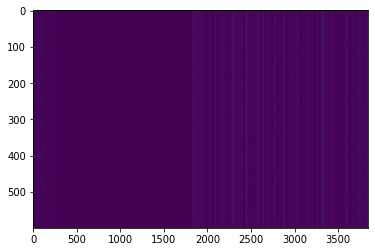

,AUC,pAUC
Source_0,0.723600,0.626842
Source_1,0.565200,0.503158
Source_2,0.697700,0.636842
Target_0,0.684800,0.643684
Target_1,0.622200,0.520000
Target_2,0.596600,0.515789
mean,0.648350,0.574386
h_mean,0.643212,0.567730


2021-05-31 23:41:17,156 - pytorch_modeler.py - INFO - epoch:8/100, train_losses:538.461360, val_AUC_hmean:0.643212, val_pAUC_hmean:0.567730, best_flag:True
2021-05-31 23:41:17,157 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.96it/s]
2021-05-31 23:41:18,164 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 57.75it/s]
2021-05-31 23:41:18,227 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 46.35it/s]
2021-05-31 23:41:18,296 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:518.952520, val_AUC_hmean:0.624533, val_pAUC_hmean:0.561415, best_flag:False
2021-05-31 23:41:18,297 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.59it/s]
2021-05-31 23:41:19,253 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 49.26it/s]
2021-05-31 23:41:19,313 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 75.77it/s]
2021-05-31 23:41:19

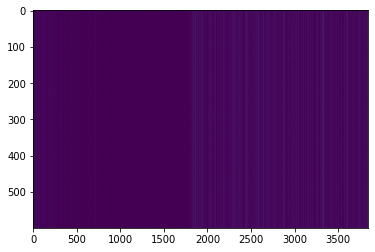

,AUC,pAUC
Source_0,0.738800,0.633158
Source_1,0.604800,0.502105
Source_2,0.744900,0.640526
Target_0,0.690200,0.645263
Target_1,0.594400,0.519474
Target_2,0.566000,0.514737
mean,0.656517,0.575877
h_mean,0.648827,0.568735


2021-05-31 23:41:27,590 - pytorch_modeler.py - INFO - epoch:16/100, train_losses:441.324704, val_AUC_hmean:0.648827, val_pAUC_hmean:0.568735, best_flag:True
2021-05-31 23:41:27,591 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.77it/s]
2021-05-31 23:41:28,612 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 68.24it/s]
2021-05-31 23:41:28,663 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 63.99it/s]


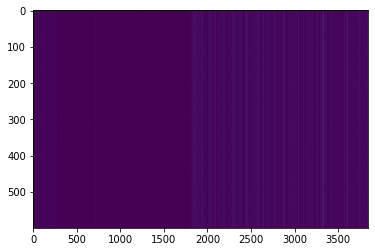

,AUC,pAUC
Source_0,0.741900,0.633158
Source_1,0.627100,0.516316
Source_2,0.748200,0.661579
Target_0,0.697000,0.665263
Target_1,0.598300,0.510000
Target_2,0.561200,0.518947
mean,0.662283,0.584211
h_mean,0.654515,0.575891


2021-05-31 23:41:30,306 - pytorch_modeler.py - INFO - epoch:17/100, train_losses:434.412669, val_AUC_hmean:0.654515, val_pAUC_hmean:0.575891, best_flag:True
2021-05-31 23:41:30,306 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.63it/s]
2021-05-31 23:41:31,258 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 59.52it/s]
2021-05-31 23:41:31,314 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 49.71it/s]
2021-05-31 23:41:31,380 - pytorch_modeler.py - INFO - epoch:18/100, train_losses:428.451520, val_AUC_hmean:0.626850, val_pAUC_hmean:0.567536, best_flag:False
2021-05-31 23:41:31,381 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.55it/s]
2021-05-31 23:41:32,339 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 50.32it/s]
2021-05-31 23:41:32,398 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 59.83it/s]
2021-05-31 23:41:

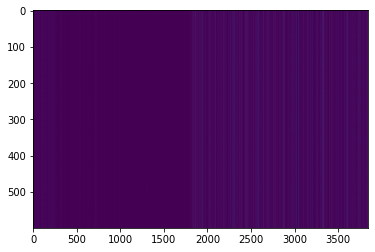

,AUC,pAUC
Source_0,0.764900,0.631579
Source_1,0.627900,0.527368
Source_2,0.776900,0.654211
Target_0,0.726100,0.655789
Target_1,0.628200,0.528947
Target_2,0.563400,0.511053
mean,0.681233,0.584825
h_mean,0.671806,0.578019


2021-05-31 23:41:49,401 - pytorch_modeler.py - INFO - epoch:33/100, train_losses:361.843252, val_AUC_hmean:0.671806, val_pAUC_hmean:0.578019, best_flag:True
2021-05-31 23:41:49,401 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 10.66it/s]
2021-05-31 23:41:50,529 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 84.29it/s]
2021-05-31 23:41:50,572 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 84.48it/s]
2021-05-31 23:41:50,631 - pytorch_modeler.py - INFO - epoch:34/100, train_losses:357.190287, val_AUC_hmean:0.651022, val_pAUC_hmean:0.564824, best_flag:False
2021-05-31 23:41:50,632 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:01<00:00, 11.79it/s]
2021-05-31 23:41:51,652 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 50.17it/s]
2021-05-31 23:41:51,715 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 46.19it/s]
2021-05-31 23:41:

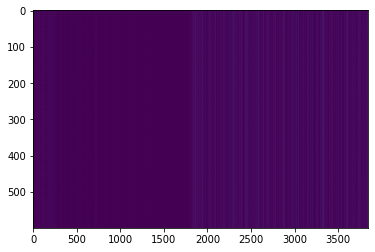

,AUC,pAUC
Source_0,0.756800,0.628421
Source_1,0.623300,0.515789
Source_2,0.800900,0.683158
Target_0,0.715800,0.664211
Target_1,0.594800,0.518947
Target_2,0.570000,0.520000
mean,0.676933,0.588421
h_mean,0.666150,0.579741


2021-05-31 23:41:54,487 - pytorch_modeler.py - INFO - epoch:36/100, train_losses:350.861132, val_AUC_hmean:0.666150, val_pAUC_hmean:0.579741, best_flag:True
2021-05-31 23:41:54,488 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.44it/s]
2021-05-31 23:41:55,454 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 78.31it/s]
2021-05-31 23:41:55,499 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 52.36it/s]
2021-05-31 23:41:55,564 - pytorch_modeler.py - INFO - epoch:37/100, train_losses:347.965009, val_AUC_hmean:0.636128, val_pAUC_hmean:0.565896, best_flag:False
2021-05-31 23:41:55,565 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 12.61it/s]
2021-05-31 23:41:56,518 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 67.38it/s]
2021-05-31 23:41:56,568 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 57.13it/s]
2021-05-31 23:41:

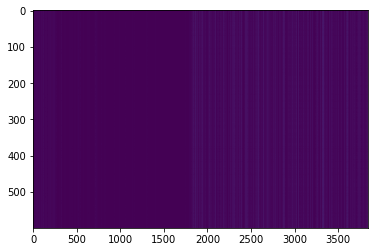

,AUC,pAUC
Source_0,0.754600,0.636316
Source_1,0.610700,0.524737
Source_2,0.796200,0.695789
Target_0,0.704500,0.663684
Target_1,0.593700,0.507368
Target_2,0.562000,0.514211
mean,0.670283,0.590351
h_mean,0.659211,0.580445


2021-05-31 23:41:59,349 - pytorch_modeler.py - INFO - epoch:39/100, train_losses:342.616155, val_AUC_hmean:0.659211, val_pAUC_hmean:0.580445, best_flag:True
2021-05-31 23:41:59,350 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.88it/s]
2021-05-31 23:41:59,900 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 97.61it/s]
2021-05-31 23:41:59,939 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 93.07it/s]
2021-05-31 23:41:59,982 - pytorch_modeler.py - INFO - epoch:40/100, train_losses:339.225614, val_AUC_hmean:0.654763, val_pAUC_hmean:0.574841, best_flag:False
2021-05-31 23:41:59,983 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.55it/s]
2021-05-31 23:42:00,542 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 99.88it/s]
2021-05-31 23:42:00,580 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.21it/s]
2021-05-31 23:42:

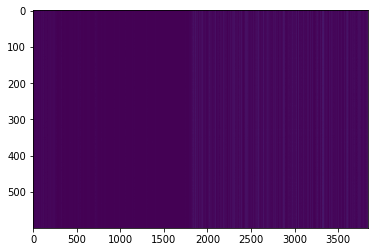

,AUC,pAUC
Source_0,0.746700,0.635263
Source_1,0.616500,0.515263
Source_2,0.790200,0.681053
Target_0,0.706400,0.663684
Target_1,0.617300,0.524737
Target_2,0.577700,0.520526
mean,0.675800,0.590088
h_mean,0.667158,0.581575


2021-05-31 23:42:09,199 - pytorch_modeler.py - INFO - epoch:52/100, train_losses:309.312742, val_AUC_hmean:0.667158, val_pAUC_hmean:0.581575, best_flag:True
2021-05-31 23:42:09,199 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.26it/s]
2021-05-31 23:42:09,766 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 87.44it/s]
2021-05-31 23:42:09,808 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 91.78it/s]
2021-05-31 23:42:09,852 - pytorch_modeler.py - INFO - epoch:53/100, train_losses:306.919912, val_AUC_hmean:0.658725, val_pAUC_hmean:0.571733, best_flag:False
2021-05-31 23:42:09,853 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.54it/s]
2021-05-31 23:42:10,413 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 98.80it/s]
2021-05-31 23:42:10,451 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 89.10it/s]
2021-05-31 23:42:

100%|██████████| 2/2 [00:00<00:00, 87.46it/s]
2021-05-31 23:42:20,525 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 88.91it/s]
2021-05-31 23:42:20,571 - pytorch_modeler.py - INFO - epoch:69/100, train_losses:272.137255, val_AUC_hmean:0.655822, val_pAUC_hmean:0.577714, best_flag:False
2021-05-31 23:42:20,572 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.51it/s]
2021-05-31 23:42:21,131 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 90.60it/s]
2021-05-31 23:42:21,171 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 97.88it/s]
2021-05-31 23:42:21,213 - pytorch_modeler.py - INFO - epoch:70/100, train_losses:270.701215, val_AUC_hmean:0.652978, val_pAUC_hmean:0.568071, best_flag:False
2021-05-31 23:42:21,214 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.12it/s]
2021-05-31 23:42:21,784 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 21.84it/s]
2021-05-31 23:42:31,613 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 95.46it/s]
2021-05-31 23:42:31,652 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 95.92it/s]
2021-05-31 23:42:31,695 - pytorch_modeler.py - INFO - epoch:86/100, train_losses:239.940114, val_AUC_hmean:0.651951, val_pAUC_hmean:0.574945, best_flag:False
2021-05-31 23:42:31,696 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.77it/s]
2021-05-31 23:42:32,249 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 94.36it/s]
2021-05-31 23:42:32,288 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 96.01it/s]
2021-05-31 23:42:32,330 - pytorch_modeler.py - INFO - epoch:87/100, train_losses:238.288837, val_AUC_hmean:0.654484, val_pAUC_hmean:0.578647, best_flag:False
2021-05-31 23:42:32,331 - pytorch_modeler.py - INFO - train
100%|██████████|

,AUC,pAUC
Source_0,0.746700,0.635263
Source_1,0.616500,0.515263
Source_2,0.790200,0.681053
Target_0,0.706400,0.663684
Target_1,0.617300,0.524737
Target_2,0.577700,0.520526
mean,0.675800,0.590088
h_mean,0.667158,0.581575


2021-05-31 23:42:40,690 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2021-05-31 23:42:40,691 - 00_train.py - INFO - MAKE DATA_LOADER
2021-05-31 23:42:40,692 - 00_train.py - INFO - TRAINING


elapsed time: 106.787264109 [sec]


2021-05-31 23:42:41,072 - pytorch_modeler.py - INFO - train
 25%|██▌       | 3/12 [00:00<00:00, 22.26it/s]

use: cuda:0


100%|██████████| 12/12 [00:00<00:00, 21.93it/s]
2021-05-31 23:42:41,621 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 98.76it/s]
2021-05-31 23:42:41,659 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 95.29it/s]


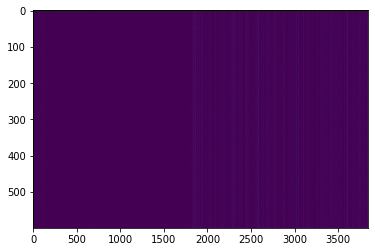

,AUC,pAUC
Source_0,0.607900,0.588947
Source_1,0.500000,0.487895
Source_2,0.395150,0.476842
Target_0,0.580600,0.556842
Target_1,0.489400,0.499474
Target_2,0.514700,0.503158
mean,0.514625,0.518860
h_mean,0.504870,0.515903


2021-05-31 23:42:43,097 - pytorch_modeler.py - INFO - epoch:1/100, train_losses:1384.192647, val_AUC_hmean:0.504870, val_pAUC_hmean:0.515903, best_flag:True
2021-05-31 23:42:43,098 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.04it/s]
2021-05-31 23:42:43,644 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 92.74it/s]
2021-05-31 23:42:43,684 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 95.16it/s]


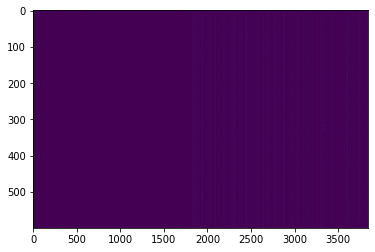

,AUC,pAUC
Source_0,0.649200,0.598947
Source_1,0.493900,0.503158
Source_2,0.447100,0.481579
Target_0,0.600600,0.595263
Target_1,0.511400,0.491579
Target_2,0.549200,0.508421
mean,0.541900,0.529825
h_mean,0.533668,0.525642


2021-05-31 23:42:45,119 - pytorch_modeler.py - INFO - epoch:2/100, train_losses:1007.254934, val_AUC_hmean:0.533668, val_pAUC_hmean:0.525642, best_flag:True
2021-05-31 23:42:45,119 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.10it/s]
2021-05-31 23:42:45,690 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 93.91it/s]
2021-05-31 23:42:45,730 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 97.70it/s]


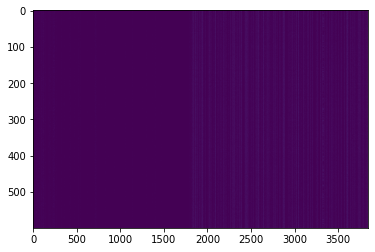

,AUC,pAUC
Source_0,0.682700,0.605789
Source_1,0.496200,0.506842
Source_2,0.540100,0.493684
Target_0,0.627500,0.602105
Target_1,0.508600,0.491053
Target_2,0.565300,0.506842
mean,0.570067,0.534386
h_mean,0.562832,0.530054


2021-05-31 23:42:47,264 - pytorch_modeler.py - INFO - epoch:3/100, train_losses:814.774267, val_AUC_hmean:0.562832, val_pAUC_hmean:0.530054, best_flag:True
2021-05-31 23:42:47,265 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.26it/s]
2021-05-31 23:42:47,831 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 96.20it/s]
2021-05-31 23:42:47,870 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 100.16it/s]


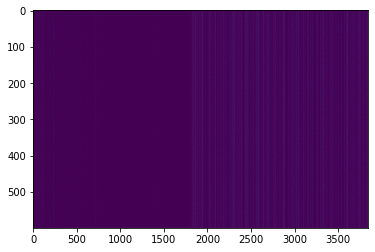

,AUC,pAUC
Source_0,0.711300,0.616316
Source_1,0.524700,0.516316
Source_2,0.646400,0.545263
Target_0,0.656900,0.605789
Target_1,0.540100,0.502105
Target_2,0.597100,0.520000
mean,0.612750,0.550965
h_mean,0.605612,0.547508


2021-05-31 23:42:49,342 - pytorch_modeler.py - INFO - epoch:4/100, train_losses:697.083165, val_AUC_hmean:0.605612, val_pAUC_hmean:0.547508, best_flag:True
2021-05-31 23:42:49,343 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.93it/s]
2021-05-31 23:42:49,892 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 91.96it/s]
2021-05-31 23:42:49,940 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.85it/s]


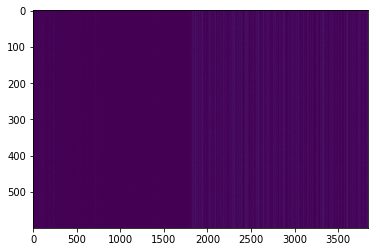

,AUC,pAUC
Source_0,0.735200,0.617895
Source_1,0.563200,0.516316
Source_2,0.680800,0.593158
Target_0,0.674300,0.621053
Target_1,0.574400,0.516842
Target_2,0.589900,0.508421
mean,0.636300,0.562281
h_mean,0.630003,0.557986


2021-05-31 23:42:51,434 - pytorch_modeler.py - INFO - epoch:5/100, train_losses:625.288971, val_AUC_hmean:0.630003, val_pAUC_hmean:0.557986, best_flag:True
2021-05-31 23:42:51,435 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.96it/s]
2021-05-31 23:42:51,983 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 100.14it/s]
2021-05-31 23:42:52,021 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.62it/s]


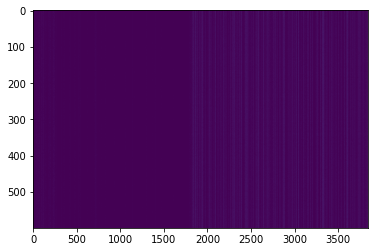

,AUC,pAUC
Source_0,0.726700,0.622105
Source_1,0.549200,0.504737
Source_2,0.678000,0.616316
Target_0,0.678300,0.622105
Target_1,0.597100,0.525263
Target_2,0.598100,0.514211
mean,0.637900,0.567456
h_mean,0.632056,0.562472


2021-05-31 23:42:53,590 - pytorch_modeler.py - INFO - epoch:6/100, train_losses:580.582530, val_AUC_hmean:0.632056, val_pAUC_hmean:0.562472, best_flag:True
2021-05-31 23:42:53,591 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.02it/s]
2021-05-31 23:42:54,138 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 99.75it/s]
2021-05-31 23:42:54,176 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 91.45it/s]


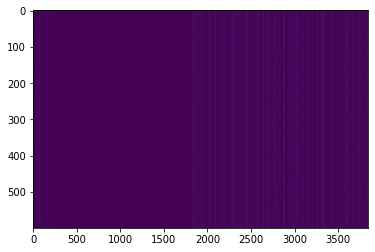

,AUC,pAUC
Source_0,0.714700,0.640526
Source_1,0.580200,0.511579
Source_2,0.691500,0.635263
Target_0,0.661400,0.641053
Target_1,0.575500,0.514211
Target_2,0.593400,0.507368
mean,0.636117,0.575000
h_mean,0.631338,0.567874


2021-05-31 23:42:55,702 - pytorch_modeler.py - INFO - epoch:7/100, train_losses:550.880508, val_AUC_hmean:0.631338, val_pAUC_hmean:0.567874, best_flag:True
2021-05-31 23:42:55,704 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 18.20it/s]
2021-05-31 23:42:56,365 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 95.47it/s]
2021-05-31 23:42:56,404 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 91.12it/s]
2021-05-31 23:42:56,448 - pytorch_modeler.py - INFO - epoch:8/100, train_losses:527.395732, val_AUC_hmean:0.641937, val_pAUC_hmean:0.567070, best_flag:False
2021-05-31 23:42:56,449 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.63it/s]
2021-05-31 23:42:57,006 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 96.19it/s]
2021-05-31 23:42:57,045 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.79it/s]


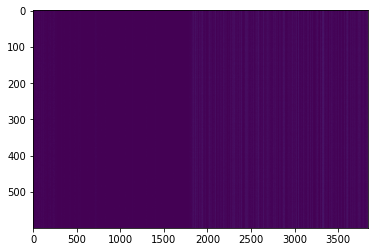

,AUC,pAUC
Source_0,0.719300,0.655263
Source_1,0.548800,0.503158
Source_2,0.696500,0.640526
Target_0,0.642200,0.647895
Target_1,0.561800,0.498947
Target_2,0.567400,0.520526
mean,0.622667,0.577719
h_mean,0.615529,0.569067


2021-05-31 23:42:58,475 - pytorch_modeler.py - INFO - epoch:9/100, train_losses:508.935211, val_AUC_hmean:0.615529, val_pAUC_hmean:0.569067, best_flag:True
2021-05-31 23:42:58,476 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.85it/s]
2021-05-31 23:42:59,027 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 99.25it/s]
2021-05-31 23:42:59,065 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 89.16it/s]
2021-05-31 23:42:59,108 - pytorch_modeler.py - INFO - epoch:10/100, train_losses:493.432040, val_AUC_hmean:0.636196, val_pAUC_hmean:0.567572, best_flag:False
2021-05-31 23:42:59,109 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.91it/s]
2021-05-31 23:42:59,659 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 99.89it/s]
2021-05-31 23:42:59,697 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 85.60it/s]
2021-05-31 23:42:5

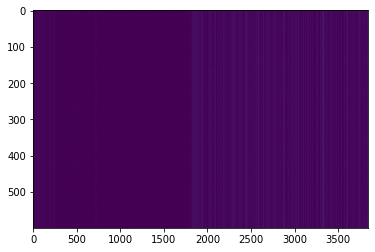

,AUC,pAUC
Source_0,0.721200,0.645789
Source_1,0.607400,0.495263
Source_2,0.718600,0.646842
Target_0,0.677000,0.649474
Target_1,0.633300,0.520000
Target_2,0.577300,0.518421
mean,0.655800,0.579298
h_mean,0.651263,0.571140


2021-05-31 23:43:02,514 - pytorch_modeler.py - INFO - epoch:13/100, train_losses:458.003492, val_AUC_hmean:0.651263, val_pAUC_hmean:0.571140, best_flag:True
2021-05-31 23:43:02,515 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 19.37it/s]
2021-05-31 23:43:03,137 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 92.86it/s]
2021-05-31 23:43:03,176 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 86.20it/s]


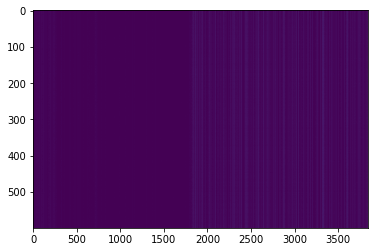

,AUC,pAUC
Source_0,0.732200,0.653684
Source_1,0.617700,0.500000
Source_2,0.732200,0.676316
Target_0,0.675700,0.656842
Target_1,0.632400,0.534211
Target_2,0.582100,0.522632
mean,0.662050,0.590614
h_mean,0.657207,0.581613


2021-05-31 23:43:04,807 - pytorch_modeler.py - INFO - epoch:14/100, train_losses:447.838244, val_AUC_hmean:0.657207, val_pAUC_hmean:0.581613, best_flag:True
2021-05-31 23:43:04,808 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.77it/s]
2021-05-31 23:43:05,361 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 97.23it/s]
2021-05-31 23:43:05,401 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.33it/s]
2021-05-31 23:43:05,443 - pytorch_modeler.py - INFO - epoch:15/100, train_losses:439.166334, val_AUC_hmean:0.635920, val_pAUC_hmean:0.572902, best_flag:False
2021-05-31 23:43:05,444 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.93it/s]
2021-05-31 23:43:05,993 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 99.08it/s]
2021-05-31 23:43:06,031 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.37it/s]
2021-05-31 23:43:

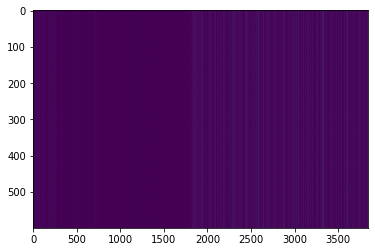

,AUC,pAUC
Source_0,0.732400,0.668421
Source_1,0.617400,0.520526
Source_2,0.771000,0.644737
Target_0,0.700600,0.656842
Target_1,0.622100,0.543158
Target_2,0.544400,0.518421
mean,0.664650,0.592018
h_mean,0.655467,0.584757


2021-05-31 23:43:15,381 - pytorch_modeler.py - INFO - epoch:28/100, train_losses:369.751884, val_AUC_hmean:0.655467, val_pAUC_hmean:0.584757, best_flag:True
2021-05-31 23:43:15,382 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.84it/s]
2021-05-31 23:43:15,959 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 75.35it/s]
2021-05-31 23:43:16,008 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 82.36it/s]
2021-05-31 23:43:16,056 - pytorch_modeler.py - INFO - epoch:29/100, train_losses:366.177269, val_AUC_hmean:0.627138, val_pAUC_hmean:0.571932, best_flag:False
2021-05-31 23:43:16,057 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 20.85it/s]
2021-05-31 23:43:16,634 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 86.63it/s]
2021-05-31 23:43:16,682 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 88.34it/s]
2021-05-31 23:43:

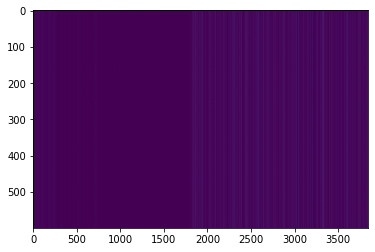

,AUC,pAUC
Source_0,0.75990,0.652105
Source_1,0.61380,0.502105
Source_2,0.78090,0.705789
Target_0,0.69100,0.651579
Target_1,0.63950,0.541053
Target_2,0.56100,0.522105
mean,0.67435,0.595789
h_mean,0.66525,0.585922


2021-05-31 23:43:23,545 - pytorch_modeler.py - INFO - epoch:38/100, train_losses:335.313314, val_AUC_hmean:0.665250, val_pAUC_hmean:0.585922, best_flag:True
2021-05-31 23:43:23,546 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.70it/s]
2021-05-31 23:43:24,101 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 88.72it/s]
2021-05-31 23:43:24,142 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 92.13it/s]
2021-05-31 23:43:24,186 - pytorch_modeler.py - INFO - epoch:39/100, train_losses:332.931953, val_AUC_hmean:0.649104, val_pAUC_hmean:0.579795, best_flag:False
2021-05-31 23:43:24,187 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.81it/s]
2021-05-31 23:43:24,739 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 93.86it/s]
2021-05-31 23:43:24,779 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 95.73it/s]
2021-05-31 23:43:

100%|██████████| 2/2 [00:00<00:00, 92.74it/s]
2021-05-31 23:43:34,253 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 93.30it/s]
2021-05-31 23:43:34,296 - pytorch_modeler.py - INFO - epoch:55/100, train_losses:292.298269, val_AUC_hmean:0.648328, val_pAUC_hmean:0.583428, best_flag:False
2021-05-31 23:43:34,297 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.99it/s]
2021-05-31 23:43:34,845 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 97.37it/s]
2021-05-31 23:43:34,883 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.48it/s]
2021-05-31 23:43:34,925 - pytorch_modeler.py - INFO - epoch:56/100, train_losses:290.103831, val_AUC_hmean:0.652557, val_pAUC_hmean:0.580720, best_flag:False
2021-05-31 23:43:34,926 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 22.00it/s]
2021-05-31 23:43:35,473 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

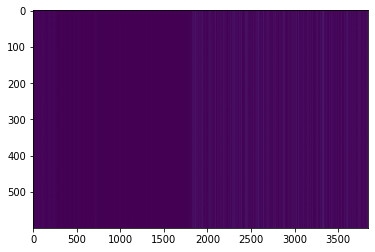

,AUC,pAUC
Source_0,0.759300,0.663684
Source_1,0.612100,0.522632
Source_2,0.800400,0.693684
Target_0,0.668700,0.652105
Target_1,0.603500,0.528947
Target_2,0.540200,0.517368
mean,0.664033,0.596404
h_mean,0.651911,0.587164


2021-05-31 23:43:38,291 - pytorch_modeler.py - INFO - epoch:59/100, train_losses:283.790049, val_AUC_hmean:0.651911, val_pAUC_hmean:0.587164, best_flag:True
2021-05-31 23:43:38,292 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.94it/s]
2021-05-31 23:43:38,840 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 98.86it/s]
2021-05-31 23:43:38,878 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 98.54it/s]
2021-05-31 23:43:38,919 - pytorch_modeler.py - INFO - epoch:60/100, train_losses:281.471903, val_AUC_hmean:0.651211, val_pAUC_hmean:0.584493, best_flag:False
2021-05-31 23:43:38,920 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.90it/s]
2021-05-31 23:43:39,470 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 93.18it/s]
2021-05-31 23:43:39,511 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 89.94it/s]
2021-05-31 23:43:

100%|██████████| 2/2 [00:00<00:00, 84.73it/s]
2021-05-31 23:43:49,704 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 73.20it/s]
2021-05-31 23:43:49,757 - pytorch_modeler.py - INFO - epoch:76/100, train_losses:249.560160, val_AUC_hmean:0.655069, val_pAUC_hmean:0.580420, best_flag:False
2021-05-31 23:43:49,760 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 19.79it/s]
2021-05-31 23:43:50,369 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 89.53it/s]
2021-05-31 23:43:50,413 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 88.82it/s]
2021-05-31 23:43:50,459 - pytorch_modeler.py - INFO - epoch:77/100, train_losses:248.232402, val_AUC_hmean:0.648813, val_pAUC_hmean:0.579992, best_flag:False
2021-05-31 23:43:50,460 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 21.33it/s]
2021-05-31 23:43:51,025 - pytorch_modeler.py - INFO - valid_source
100%|██████████|

100%|██████████| 12/12 [00:00<00:00, 19.66it/s]
2021-05-31 23:44:01,331 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 91.20it/s]
2021-05-31 23:44:01,371 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 72.71it/s]
2021-05-31 23:44:01,421 - pytorch_modeler.py - INFO - epoch:93/100, train_losses:222.044811, val_AUC_hmean:0.664409, val_pAUC_hmean:0.584771, best_flag:False
2021-05-31 23:44:01,422 - pytorch_modeler.py - INFO - train
100%|██████████| 12/12 [00:00<00:00, 19.79it/s]
2021-05-31 23:44:02,031 - pytorch_modeler.py - INFO - valid_source
100%|██████████| 2/2 [00:00<00:00, 81.68it/s]
2021-05-31 23:44:02,074 - pytorch_modeler.py - INFO - valid_target
100%|██████████| 2/2 [00:00<00:00, 83.27it/s]
2021-05-31 23:44:02,131 - pytorch_modeler.py - INFO - epoch:94/100, train_losses:219.468016, val_AUC_hmean:0.656614, val_pAUC_hmean:0.583876, best_flag:False
2021-05-31 23:44:02,132 - pytorch_modeler.py - INFO - train
100%|██████████|

,AUC,pAUC
Source_0,0.759300,0.663684
Source_1,0.612100,0.522632
Source_2,0.800400,0.693684
Target_0,0.668700,0.652105
Target_1,0.603500,0.528947
Target_2,0.540200,0.517368
mean,0.664033,0.596404
h_mean,0.651911,0.587164


elapsed time: 85.582460642 [sec]


In [15]:
for machine_type in machine_types:
    run(machine_type)

In [16]:
#run(machine_types[2])